In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

Factor Group        Field ID         Field Name FactSet Screening Formula  \
0   Asset Data  DAYS_SINCE_RPT  Days Since Report     QFL_DAYS_SINCE_RPT(0)   
1   Asset Data     DAYS_TO_RPT     Days to Report        QFL_DAYS_TO_RPT(0)   
2   Asset Data        ADR_FLAG           ADR Flag           QFL_ADR_FLAG(0)   
3   Asset Data      BANKRUPTCY    Bankruptcy Flag         QFL_BANKRUPTCY(0)   
4   Asset Data    PRIMARY_LIST    Primary Listing       QFL_PRIMARY_LIST(0)   

              Data Source                                     Unnamed: 6  \
0       FactSet Estimates  'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',   
1       FactSet Estimates        'Days to Report': 'QFL_DAYS_TO_RPT(0)',   
2  FactSet Reference Data                 'ADR Flag': 'QFL_ADR_FLAG(0)',   
3  FactSet Reference Data        'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',   
4  FactSet Reference Data      'Primary Listing': 'QFL_PRIMARY_LIST(0)',   

  Currency  Shares CACCESS       Search Keywords Data Type String Length  
0     None       0   00QFL  asset,data,estimates   INTEGER           NaN  
1     None       0   00QFL  asset,data,estimates   INTEGER           NaN  
2     None       0   00QFL  asset,reference,data   INTEGER           NaN  
3     None       0   00QFL  asset,reference,data   INTEGER           NaN  
4     None       0   00QFL  asset,reference,data   INTEGER           NaN

In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = qfl_profitability # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

BENCHMARK_ID         DATE SECURITY_ID    Weight             proper_name  \
0        890100  30-Nov-2020    03783310  4.204100              Apple Inc.   
1        890100  30-Nov-2020    59491810  3.141281   Microsoft Corporation   
2        890100  30-Nov-2020    02313510  2.735749        Amazon.com, Inc.   
3        890100  30-Nov-2020    30303M10  1.356526  Facebook, Inc. Class A   
4        890100  30-Nov-2020    02079K10  1.085045   Alphabet Inc. Class C   

           fg_gics_sector         proper  p_total_return qfl_size_class  \
0  Information Technology  United States       11.457372       Mega Cap   
1  Information Technology  United States        3.900588       Mega Cap   
2  Consumer Discretionary  United States        2.805829       Mega Cap   
3  Communication Services  United States       -1.375598       Mega Cap   
4  Communication Services  United States       -0.503194       Mega Cap   

   qfl_mkt_val_sec  QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  \
0        2024064.4      17.495182       17.334135       20.581772   
1        1618475.4      16.383467       15.064973       16.411192   
2        1589567.8       7.325403        5.974798        6.859622   
3         665827.3      18.522102       16.024446       18.347730   
4         580810.4      12.845562       13.502234       12.067489   

   QFL_ROA(0,FY2)  QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  \
0       21.597366       19.915457       16.531977       13.965553   
1       16.463854       17.188112             NaN             NaN   
2        7.127007        8.813777       10.137152       11.324541   
3       16.923254       17.261969       17.923240       17.715437   
4       12.656469       12.820989       13.110156       13.594206   

   QFL_ROA_CHG(0,LT)  QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  \
0          -3.813445           -0.258195            5.624497   
1          10.845449           21.400750           25.438917   
2          20.001276           43.456398           29.352260   
3           3.834396           13.723839           -0.993961   
4           1.192519            2.536368            4.471326   

   QFL_ROA_CHG(0,3YR)  QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  \
0            7.707214            6.247187           10.890425   
1           45.777320           31.695759            3.801775   
2           31.551147           -8.634085            9.943914   
3          -10.664331          -13.144445           14.429867   
4           16.086578            5.084801           -8.487946   

   QFL_ROA_CHG(0,5YR_FWD)  QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  \
0               -5.063919               -1.268605                4.755837   
1                     NaN                     NaN                4.067971   
2               13.984398               13.973723               12.800846   
3                1.297485                1.643005                1.433716   
4                0.847786                0.016328               -1.070839   

   QFL_ROA_CHG(0,2YR_FWD)  QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0,CT)  \
0               11.621874               18.735504       32.092083   
1                4.539778                8.936083       24.711168   
2                9.217440               14.809263       12.697678   
3                2.766228               14.498377       21.888575   
4               -3.182589              -10.625988       16.175348   

   QFL_ROIC(0,FY0)  QFL_ROIC(0,FY1)  QFL_ROIC(0,FY2)  QFL_ROIC(0,FY3)  \
0        31.912125        42.259876        46.953262        46.197777   
1        21.235376        27.484417        26.968940        27.723780   
2        13.208933        17.360264        16.614810        18.784160   
3        23.880419        23.705614        21.279350        21.211336   
4        15.858176        16.030617        16.541656        16.464525   

   QFL_ROIC(0,FY4)  QFL_ROIC(0,FY5)  QFL_ROIC_CHG(0,LT)  QFL_ROIC_CHG(0,5YR)  \
0        29.589880        20.669245           -5.789325             2.916956   


In [9]:
qfl_df.tail()

BENCHMARK_ID         DATE SECURITY_ID    Weight  \
1595        890100  30-Nov-2020      BZ22BK  0.002738   
1596        890100  30-Nov-2020      B2NT8S  0.002637   
1597        890100  30-Nov-2020      BKSLS5  0.002617   
1598        890100  30-Nov-2020      659844  0.002463   
1599        890100  30-Nov-2020      656950  0.002419   

                                     proper_name          fg_gics_sector  \
1595   SmartCentres Real Estate Investment Trust             Real Estate   
1596                            Seven Bank, Ltd.              Financials   
1597  First Capital Real Estate Investment Trust             Real Estate   
1598               Mitsubishi Motors Corporation  Consumer Discretionary   
1599                    Maruichi Steel Tube Ltd.               Materials   

      proper  p_total_return qfl_size_class  qfl_mkt_val_sec  QFL_ROA(0,CT)  \
1595  Canada       -3.552645        Mid Cap        2688.3582       1.201806   
1596   Japan       -4.803491        Mid Cap        2619.2988       2.421886   
1597  Canada      -12.513375        Mid Cap        2634.8494       1.548515   
1598   Japan       15.425528        Mid Cap        2808.4746     -12.857943   
1599   Japan        4.007292      Small Cap        2063.3816       2.459806   

      QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  QFL_ROA(0,FY3)  \
1595        3.835927        1.060880        3.421819        3.292215   
1596        2.378841        2.159939        2.049070        1.978547   
1597        3.885987        0.594491        2.303547        2.403671   
1598       -1.318838      -17.022030       -0.453034        1.456539   
1599        2.032687        3.300313        3.915555        3.968373   

      QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  QFL_ROA_CHG(0,5YR)  \
1595             NaN             NaN          -0.176746          -11.131727   
1596        1.944669        2.195775          -3.694353           -8.165646   
1597             NaN             NaN          -3.962629           -8.453542   
1598        1.303159        2.247421                NaN                 NaN   
1599        4.062356        4.047052           8.128568           -7.408452   

      QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  QFL_ROA_CHG(0,2YR)  \
1595          -16.576840          -26.020086          -41.856373   
1596           -7.561594           -0.074011           61.761950   
1597          -23.437256          -30.975830          -28.412354   
1598                 NaN                 NaN                 NaN   
1599          -21.510761          -30.349117          -38.717037   

      QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  QFL_ROA_CHG(0,4YR_FWD)  \
1595          -70.930490                     NaN                     NaN   
1596            2.812576               -2.121120               -4.789125   
1597          -48.754684                     NaN                     NaN   
1598                 NaN                     NaN                     NaN   
1599          -39.228970               12.363096               16.989594   

      QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  QFL_ROA_CHG(0,1YR_FWD)  \
1595                7.385191               -5.551880              -72.343570   
1596               -5.874821               -7.189805               -9.202051   
1597               -0.862669              -23.007603              -84.701660   
1598                     NaN                     NaN                     NaN   
1599               24.332994               38.791030               62.362100   

      QFL_ROIC(0,CT)  QFL_ROIC(0,FY0)  QFL_ROIC(0,FY1)  QFL_ROIC(0,FY2)  \
1595        1.441749              NaN         1.120167         3.723962   
1596        8.185129              NaN              NaN              NaN   
1597        1.794410              NaN         0.669084         2.653625   
1598      -26.069890         14.94112       -43.389484        -1.404460   
1599        2.996094          5.33969         3.965943         4.802508   

      QFL_ROIC(0,FY3)  QF

In [10]:
# Summary Stats

qfl_df.describe()

BENCHMARK_ID       Weight  p_total_return  qfl_mkt_val_sec  \
count        1600.0  1600.000000     1597.000000     1.598000e+03   
mean       890100.0     0.062500        3.118575     3.489420e+04   
std             0.0     0.177252        7.256757     9.150908e+04   
min        890100.0     0.002419      -31.602722     2.063382e+03   
25%        890100.0     0.012927       -1.169592     8.494103e+03   
50%        890100.0     0.024960        2.384615     1.491753e+04   
75%        890100.0     0.057592        6.821418     3.202311e+04   
max        890100.0     4.204100       53.399338     2.024064e+06   

       QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
count    1596.000000     1541.000000     1536.000000     1525.000000   
mean        3.797433        6.271114        4.821990        5.944590   
std         7.508304       16.764204        6.969273        5.972763   
min       -56.562930      -76.786064      -50.327850      -28.484049   
25%         0.533736        2.201798        1.179597        2.231158   
50%         2.946592        4.739360        3.787320        4.626064   
75%         6.561754        8.628287        7.507421        8.283704   
max        52.554356      598.493650       53.647190       46.942158   

       QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
count     1521.000000     1155.000000      645.000000        1518.000000   
mean         6.515288        6.977563        7.358153           4.841145   
std          5.814698        5.696992        5.594788          14.421408   
min        -26.271656       -5.701104       -0.471891         -82.640560   
25%          2.676464        3.155078        3.522305          -1.152359   
50%          5.176649        5.684747        6.185171           2.731771   
75%          8.863031        9.279107        9.575245           8.180000   
max         47.951958       48.671112       50.296410         177.514910   

       QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
count         1346.000000         1336.000000         1387.000000   
mean             0.964110            0.417765           -2.484250   
std             19.080646           30.579327           35.337628   
min            -50.175823          -71.843340          -79.855896   
25%             -7.829384          -10.710925          -18.232873   
50%             -0.488368           -1.893069           -5.860734   
75%              7.435170            6.822911            5.922031   
max            207.588750          576.652100          413.338320   

       QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
count         1403.000000         1413.000000              593.000000   
mean            -7.975857           13.389732                8.142685   
std             42.935324          325.534163               13.303815   
min            -98.081650          -99.775110              -24.775185   
25%            -28.363475          -42.509860                0.641506   
50%            -12.215686          -18.007296                5.180792   
75%              2.437193            2.936101               11.586321   
max            461.335700         8854.184000              103.212460   

       QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
count             1076.000000             1423.000000             1403.000000   
mean                 7.304554                5.613871                2.640666   
std                 16.571248               22.144453               41.347907   
min                -54.388092              -76.969666              -90.750410   
25%                 -0.363646               -2.844484              -10.249740   
50%                  3.959094                2.033755               -1.669231   
75%                 10.349901                9.068847                7.291013   
max                162.192720              306.022640              742.282500   

       QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                    0
DATE                            0
SECURITY_ID                     0
Weight                          0
proper_name                     0
                             ... 
QFL_GPROIC_CHG(0,5YR_FWD)    1599
QFL_GPROIC_CHG(0,4YR_FWD)    1599
QFL_GPROIC_CHG(0,3YR_FWD)    1599
QFL_GPROIC_CHG(0,2YR_FWD)    1599
QFL_GPROIC_CHG(0,1YR_FWD)    1599
Length: 390, dtype: int64

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

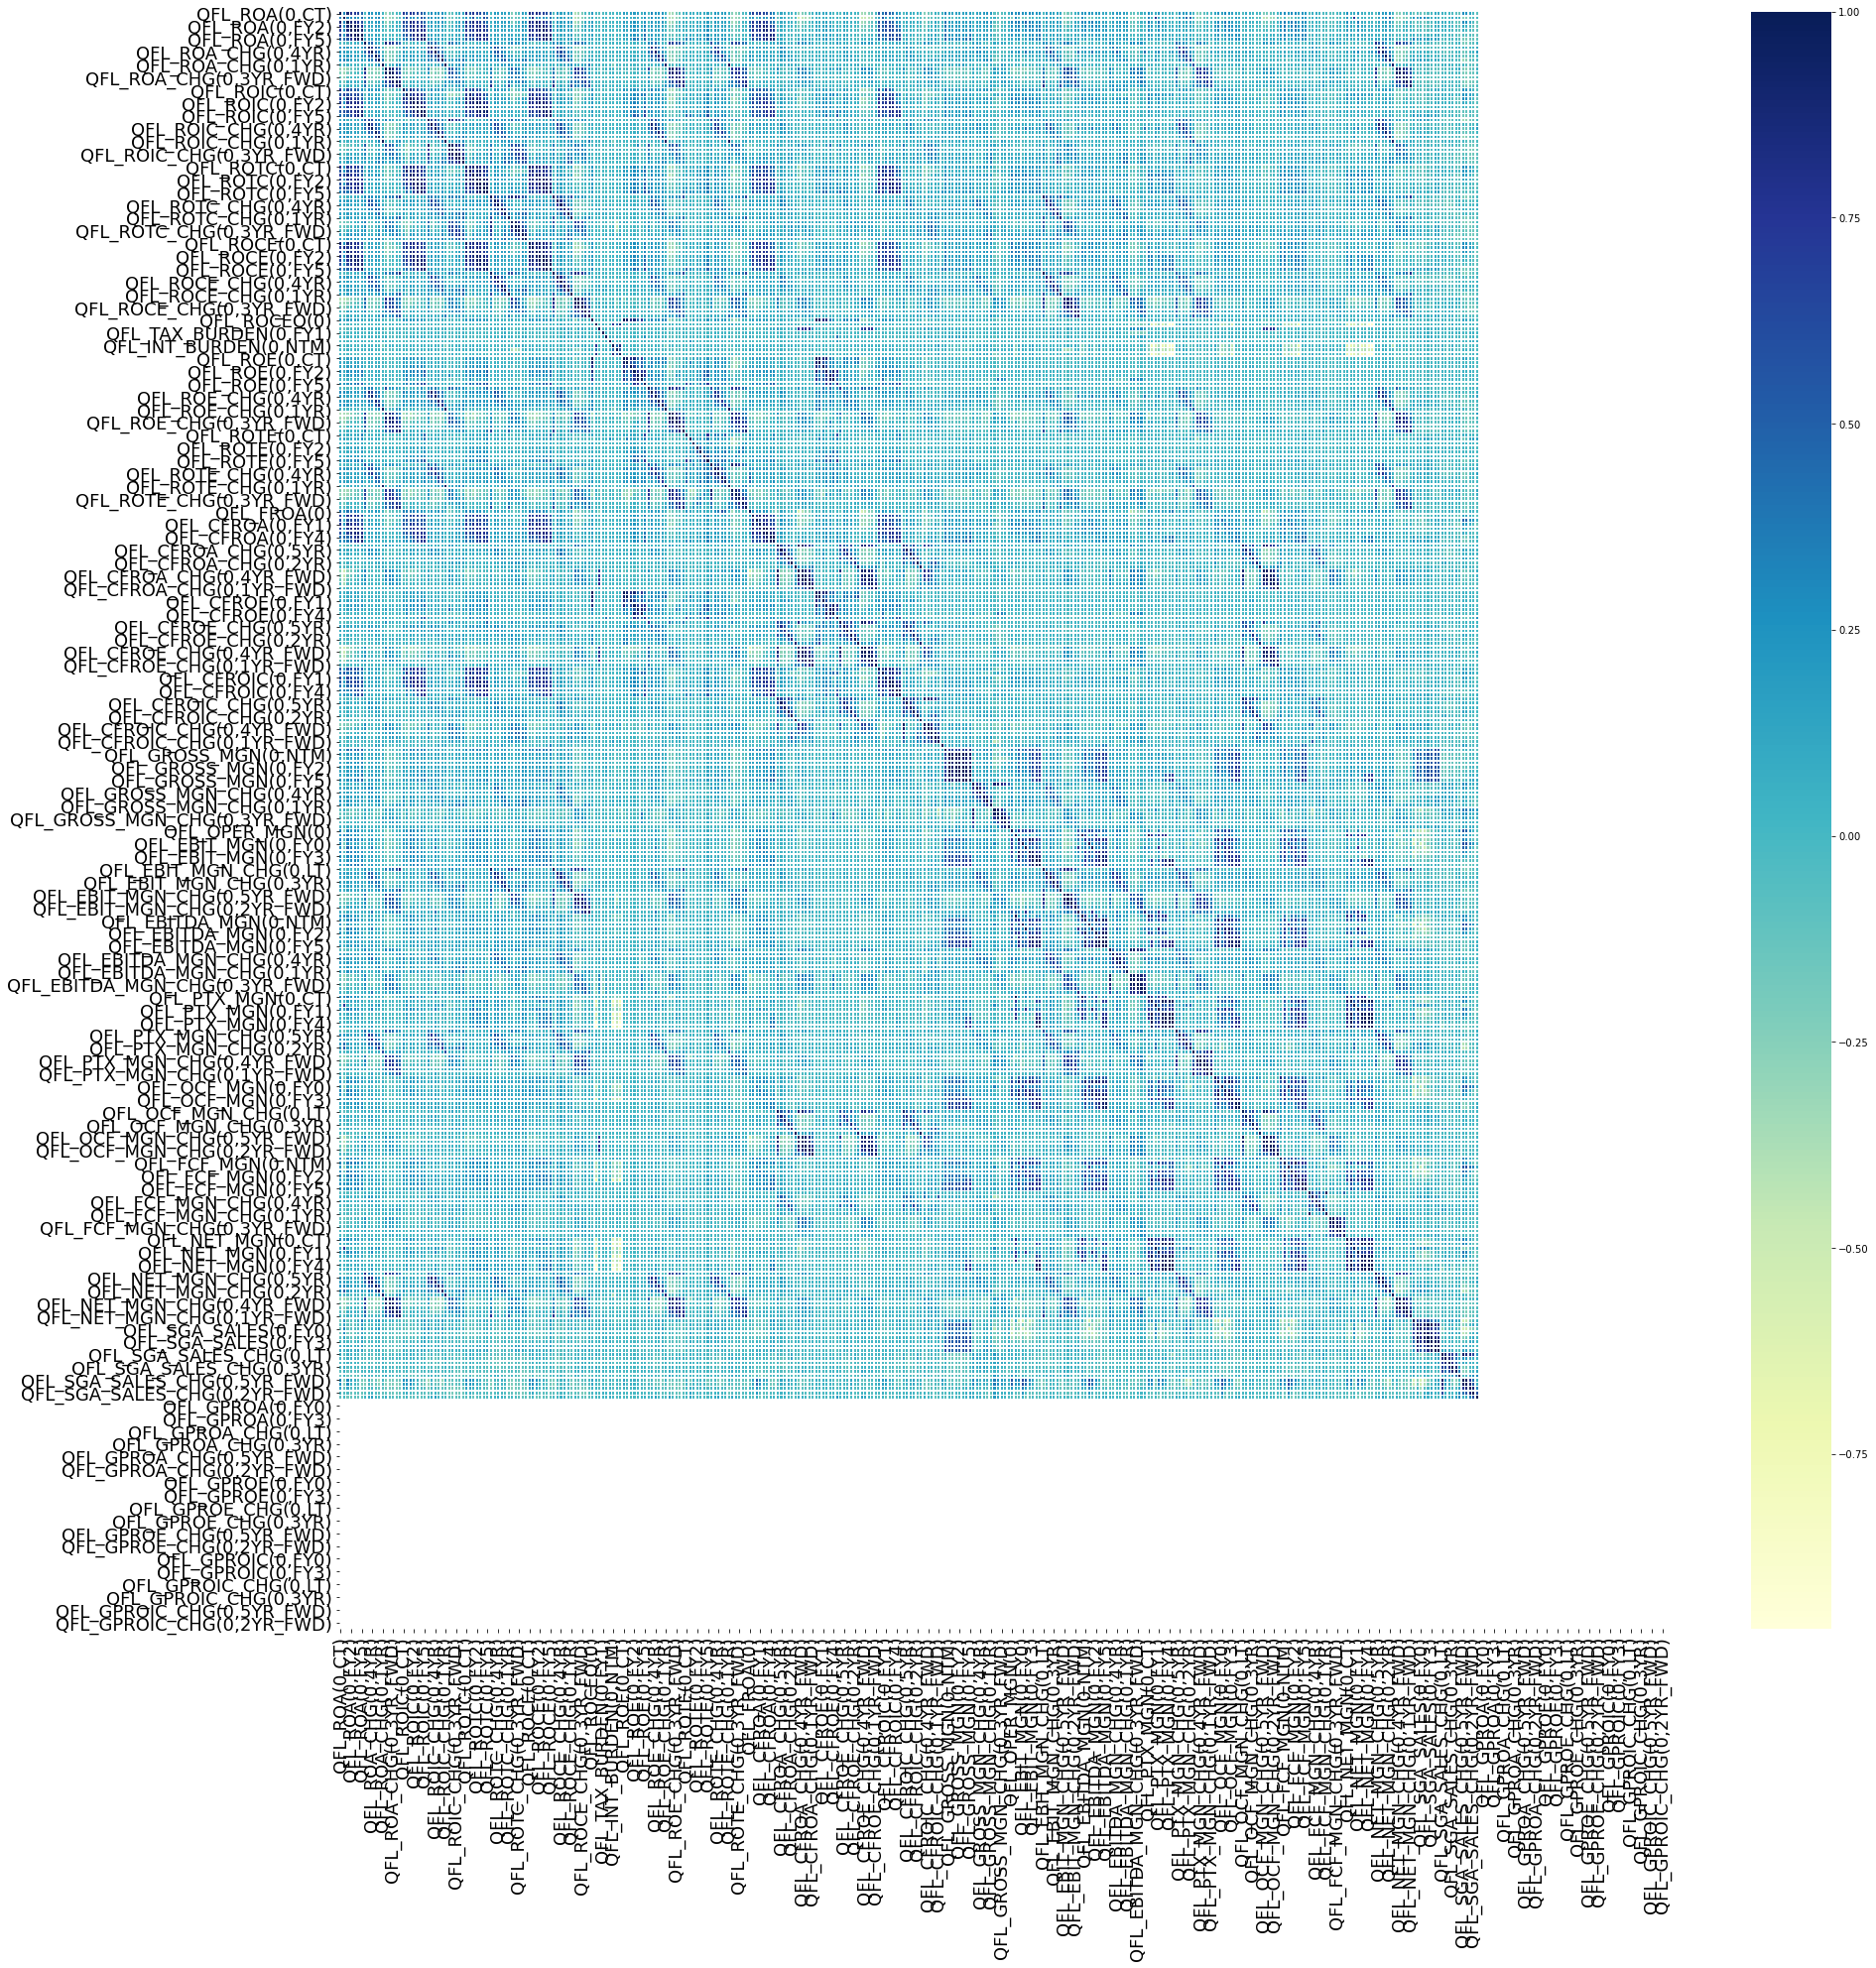

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

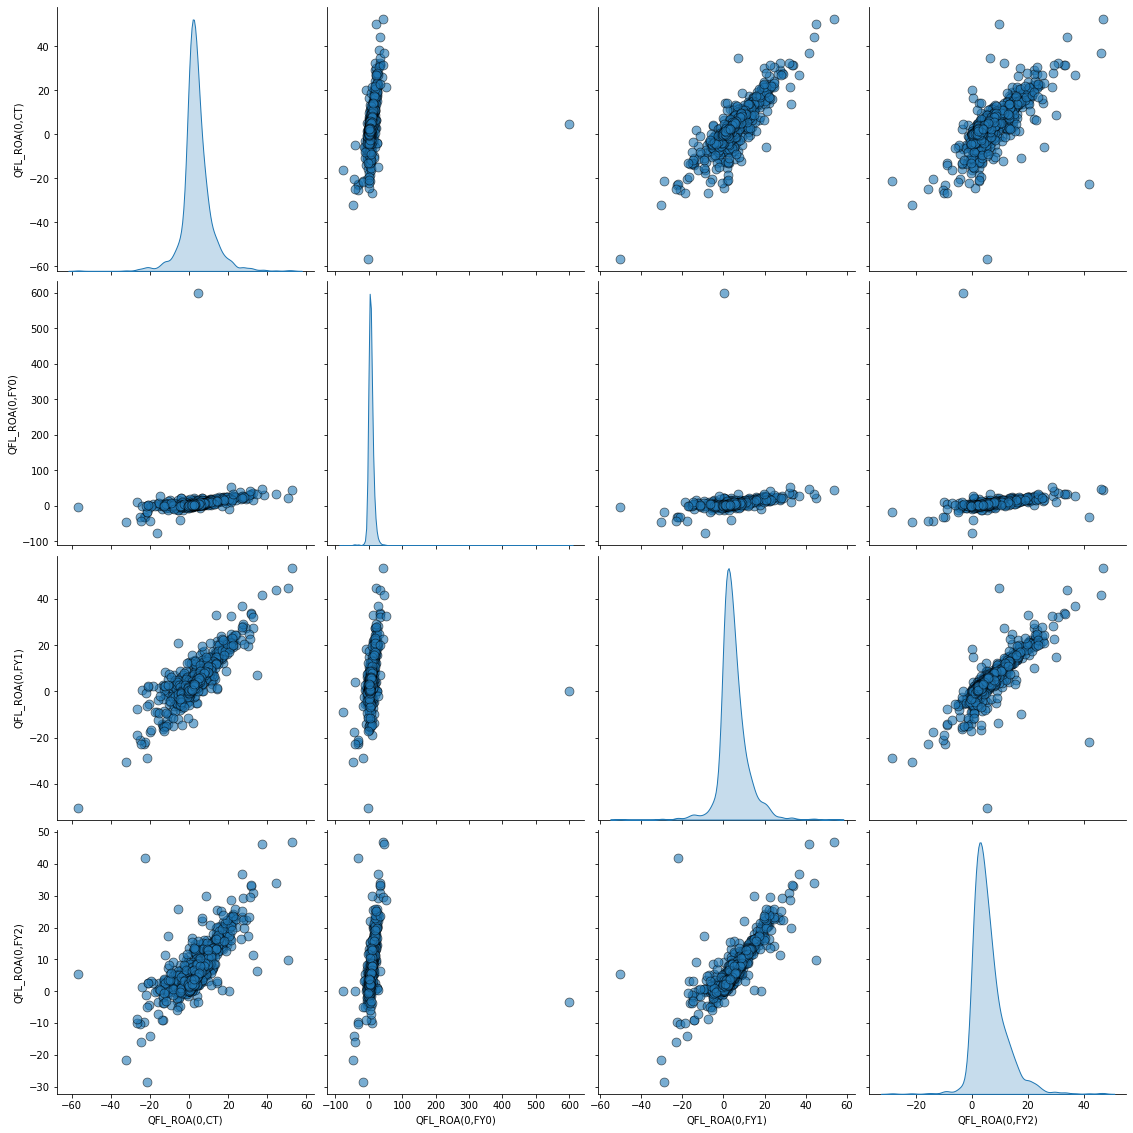

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)
0         17.495182       17.334135       20.581772       21.597366
1         16.383467       15.064973       16.411192       16.463854
2          7.325403        5.974798        6.859622        7.127007
3         18.522102       16.024446       18.347730       16.923254
4         12.845562       13.502234       12.067489       12.656469
...             ...             ...             ...             ...
1595       1.201806        3.835927        1.060880        3.421819
1596       2.421886        2.378841        2.159939        2.049070
1597       1.548515        3.885987        0.594491        2.303547
1598     -12.857943       -1.318838      -17.022030       -0.453034
1599       2.459806        2.032687        3.300313        3.915555

[1600 rows x 4 columns]

In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

C:\Users\ffais\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ffais\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nobs            minmax  mean variance skewness  \
QFL_ROA(0,CT)              1596   [-56.56, 52.55]   3.8    56.37     0.34   
QFL_ROA(0,FY0)             1541  [-76.79, 598.49]  6.27   281.04    28.56   
QFL_ROA(0,FY1)             1536   [-50.33, 53.65]  4.82    48.57     0.53   
QFL_ROA(0,FY2)             1525   [-28.48, 46.94]  5.94    35.67     1.45   
QFL_ROA(0,FY3)             1521   [-26.27, 47.95]  6.52    33.81     1.59   
...                         ...               ...   ...      ...      ...   
QFL_GPROIC_CHG(0,5YR_FWD)     1        [0.0, 0.0]     0      NaN        0   
QFL_GPROIC_CHG(0,4YR_FWD)     1        [0.0, 0.0]     0      NaN        0   
QFL_GPROIC_CHG(0,3YR_FWD)     1        [0.0, 0.0]     0      NaN        0   
QFL_GPROIC_CHG(0,2YR_FWD)     1        [0.0, 0.0]     0      NaN        0   
QFL_GPROIC_CHG(0,1YR_FWD)     1        [0.0, 0.0]     0      NaN        0   

                          kurtosis  
QFL_ROA(0,CT)                 8.15  
QFL_ROA(0,FY0)              1009.8  
QFL_ROA(0,FY1)                8.45  
QFL_ROA(0,FY2)                6.67  
QFL_ROA(0,FY3)                6.13  
...                            ...  
QFL_GPROIC_CHG(0,5YR_FWD)       -3  
QFL_GPROIC_CHG(0,4YR_FWD)       -3  
QFL_GPROIC_CHG(0,3YR_FWD)       -3  
QFL_GPROIC_CHG(0,2YR_FWD)       -3  
QFL_GPROIC_CHG(0,1YR_FWD)       -3  

[380 rows x 6 columns]

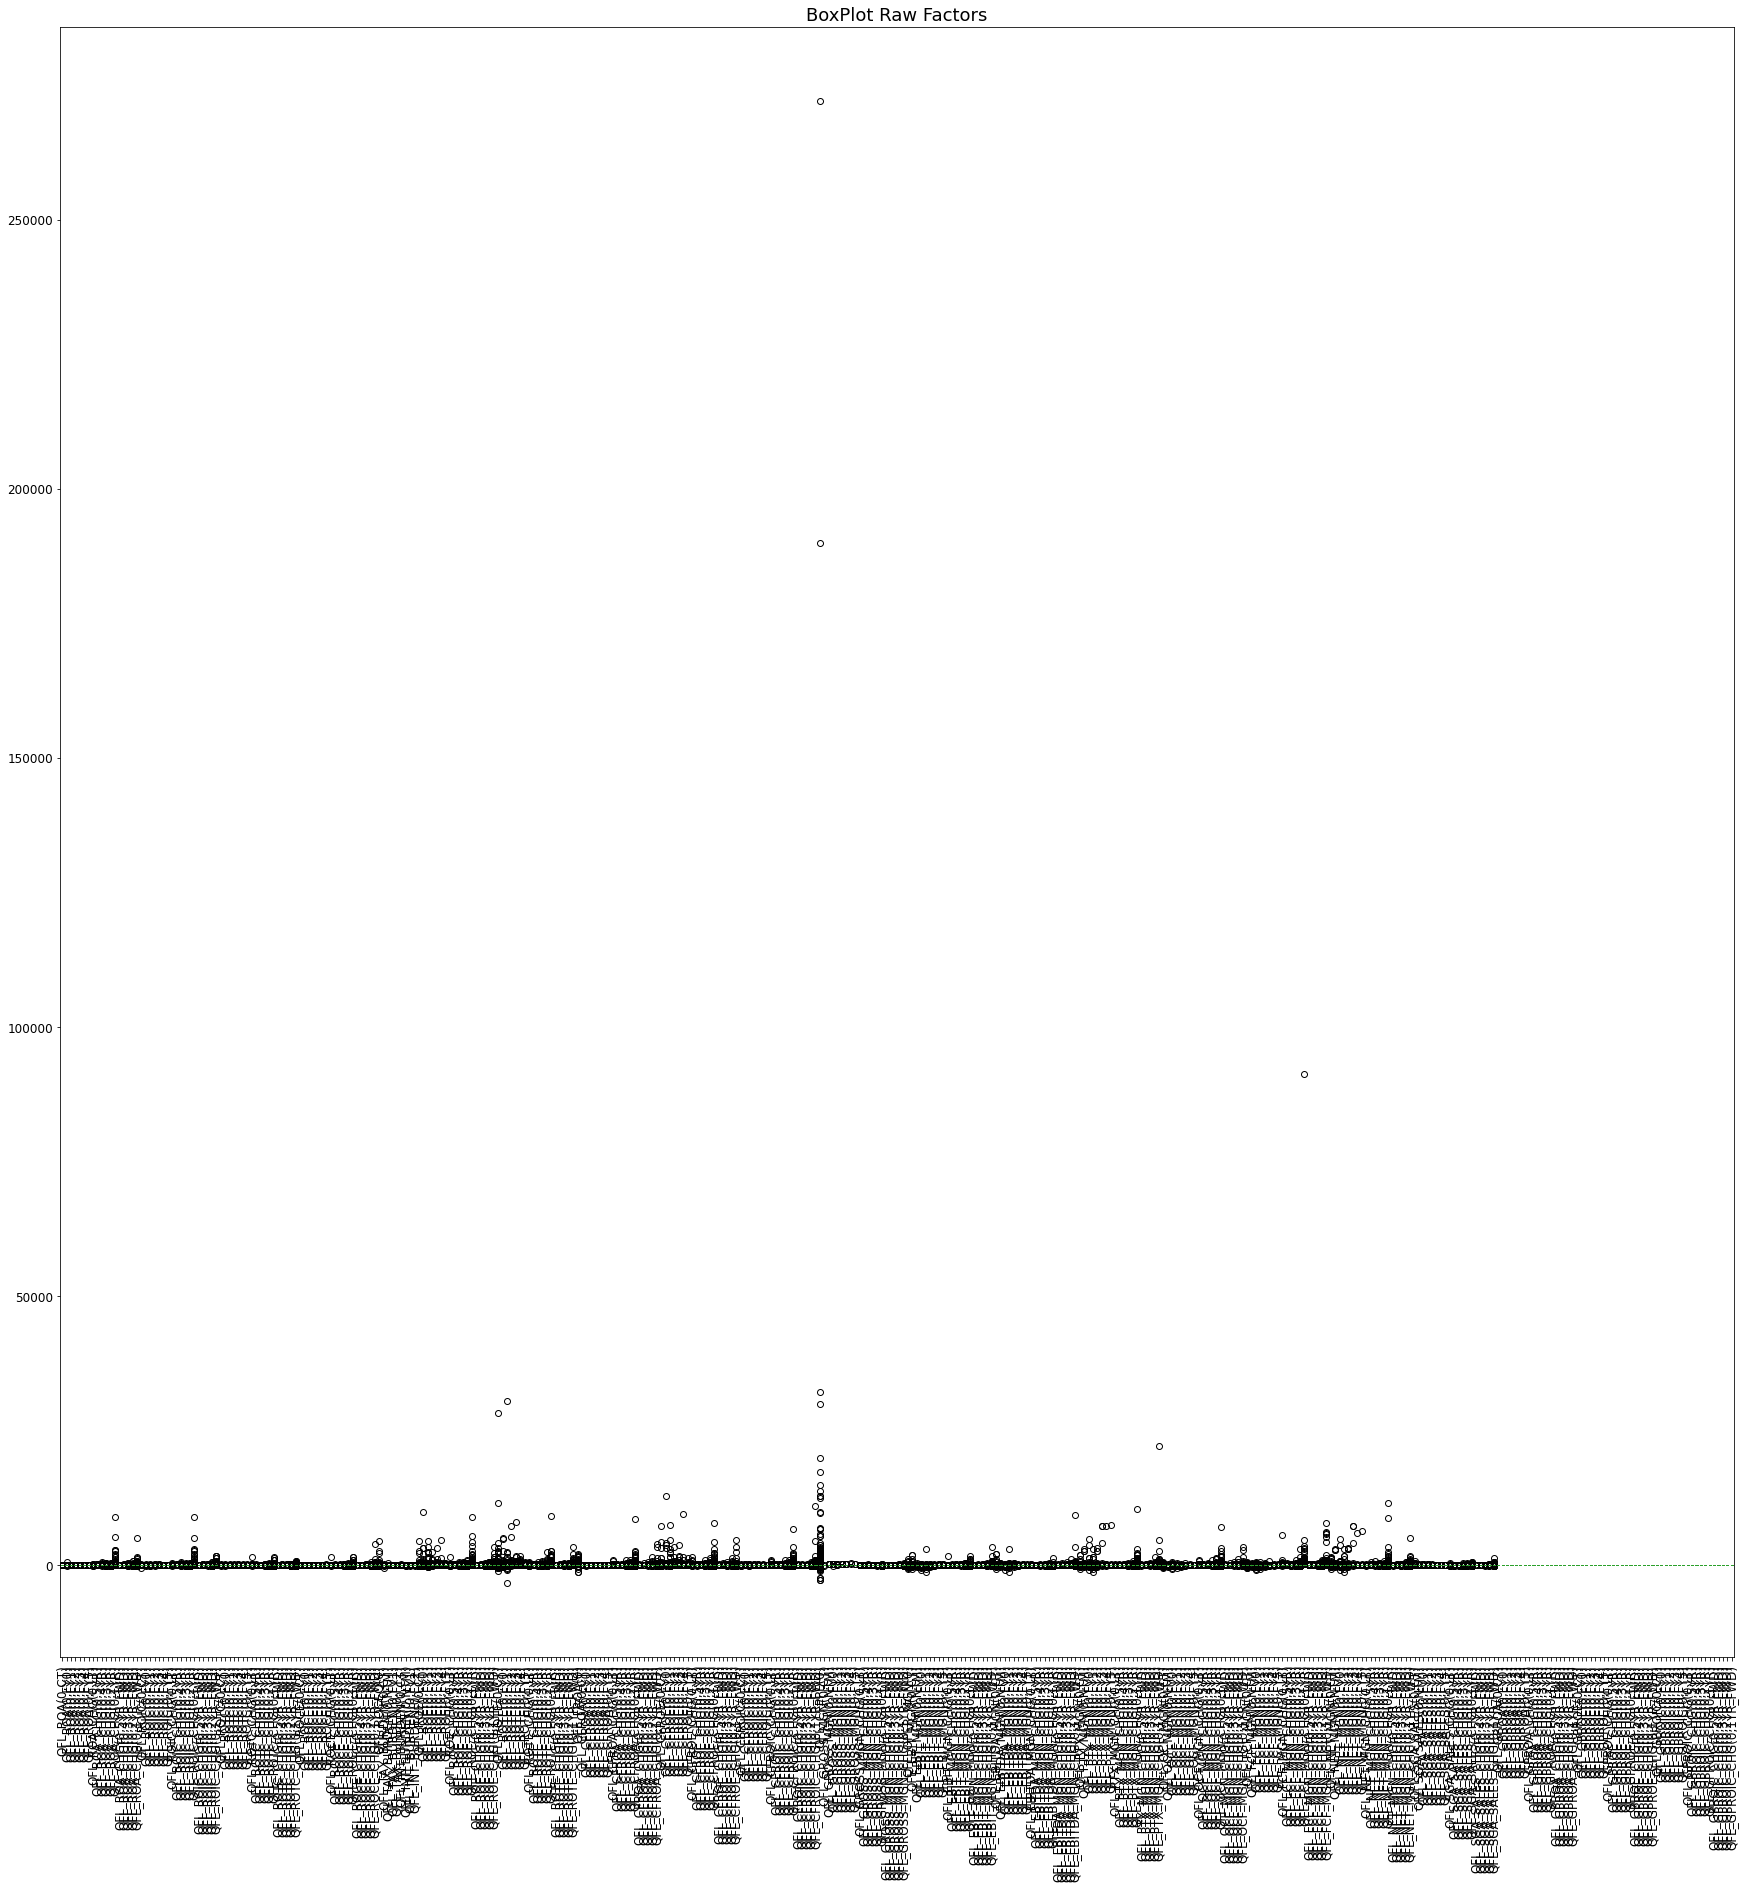

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
count   1.596000e+03    1.541000e+03    1.536000e+03    1.525000e+03   
mean   -1.270722e-15   -2.426136e-16   -6.777890e-16    1.080374e-16   
std     1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00   
min    -8.039148e+00   -4.954436e+00   -7.913285e+00   -5.764273e+00   
25%    -4.346784e-01   -2.427384e-01   -5.226359e-01   -6.217276e-01   
50%    -1.133200e-01   -9.137051e-02   -1.484617e-01   -2.207564e-01   
75%     3.681686e-01    1.406075e-01    3.853244e-01    3.916301e-01   
max     6.493734e+00    3.532661e+01    7.005781e+00    6.864087e+00   

       QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
count    1.521000e+03    1.155000e+03    6.450000e+02       1.518000e+03   
mean    -6.116811e-16   -6.622889e-17   -1.383217e-15       6.440281e-16   
std      1.000000e+00    1.000000e+00    1.000000e+00       1.000000e+00   
min     -5.638632e+00   -2.225502e+00   -1.399525e+00      -6.066100e+00   
25%     -6.601933e-01   -6.709655e-01   -6.856109e-01      -4.155977e-01   
50%     -2.302165e-01   -2.269295e-01   -2.096561e-01      -1.462669e-01   
75%      4.037600e-01    4.039929e-01    3.962781e-01       2.315207e-01   
max      7.126195e+00    7.318521e+00    7.674689e+00       1.197343e+01   

       QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
count        1.346000e+03        1.336000e+03        1.387000e+03   
mean        -1.339114e-16       -1.131829e-16       -6.339558e-17   
std          1.000000e+00        1.000000e+00        1.000000e+00   
min         -2.680199e+00       -2.363070e+00       -2.189497e+00   
25%         -4.608593e-01       -3.639285e-01       -4.456616e-01   
50%         -7.612306e-02       -7.556849e-02       -9.554925e-02   
75%          3.391426e-01        2.094600e-01        2.378847e-01   
max          1.082902e+01        1.884392e+01        1.176713e+01   

       QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
count        1.403000e+03        1.413000e+03            5.930000e+02   
mean         9.440457e-17       -3.396277e-17           -8.487683e-16   
std          1.000000e+00        1.000000e+00            1.000000e+00   
min         -2.098640e+00       -3.476282e-01           -2.474318e+00   
25%         -4.748449e-01       -1.717165e-01           -5.638367e-01   
50%         -9.874919e-02       -9.644772e-02           -2.226349e-01   
75%          2.425287e-01       -3.211224e-02            2.588457e-01   
max          1.093066e+01        2.715781e+01            7.146054e+00   

       QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
count            1.076000e+03            1.423000e+03            1.403000e+03   
mean             8.153329e-16           -3.120796e-18            5.016974e-17   
std              1.000000e+00            1.000000e+00            1.000000e+00   
min             -3.722873e+00           -3.729310e+00           -2.258665e+00   
25%             -4.627412e-01           -3.819627e-01           -3.117548e-01   
50%             -2.018834e-01           -1.616710e-01           -1.042350e-01   
75%              1.837730e-01            1.560199e-01            1.124687e-01   
max              9.346802e+00            1.356587e+01            1.788825e+01   

       QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0,CT)  QFL_ROIC(0,FY0)  \
count            1.324000e+03    1.596000e+03     1.309000e+03   
mean            -4.746120e-17   -5.368165e-16     3.271723e-16   
std              1.000000e+00    1.000000e+00     1.000000e+00   
min             -6.125049e-01   -2.588328e+01    -9.966301e+00   
25%             -2.033606e-01   -2.576695e-01    -4.854209e-01   
50%             -7.876562e-02   -4.650331e-02    -1.714922e-01   
75%              2.424414e-02    2.507984e-01     2.742183e-01   
max              3.000903e+01    1.247368e+01     1.288789e+01   

       QFL_ROIC(0,FY1)  QFL_ROIC(0,FY2)  QFL_ROIC(0,FY3)  QFL_ROIC(0

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
0          6.493734       35.326613        7.005781        6.864087   
1          6.201669        2.734208        5.747718        6.740558   
2          5.405348        2.405029        5.623900        6.039116   
3          4.678774        2.244968        5.270438        5.194297   
4          4.592252        2.145498        4.607316        4.680490   
...             ...             ...             ...             ...   
1595      -8.039148             NaN             NaN             NaN   
1596            NaN             NaN             NaN             NaN   
1597            NaN             NaN             NaN             NaN   
1598            NaN             NaN             NaN             NaN   
1599            NaN             NaN             NaN             NaN   

      QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
0           7.126195        7.318521        7.674689          11.973433   
1           6.026136        6.153152        6.023773           8.542317   
2           5.452701        5.307585        5.228907           6.887443   
3           5.230541        5.045291        4.808650           6.821200   
4           5.129646        4.666804        4.367642           6.721504   
...              ...             ...             ...                ...   
1595             NaN             NaN             NaN                NaN   
1596             NaN             NaN             NaN                NaN   
1597             NaN             NaN             NaN                NaN   
1598             NaN             NaN             NaN                NaN   
1599             NaN             NaN             NaN                NaN   

      QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
0              10.829017           18.843918           11.767133   
1               9.671709           14.977109           10.840880   
2               7.252963            6.140660            7.380822   
3               6.964181            5.250688            7.184249   
4               5.063844            5.151958            7.026773   
...                  ...                 ...                 ...   
1595                 NaN                 NaN                 NaN   
1596                 NaN                 NaN                 NaN   
1597                 NaN                 NaN                 NaN   
1598                 NaN                 NaN                 NaN   
1599                 NaN                 NaN                 NaN   

      QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
0              10.930663           27.157808                7.146054   
1               8.383047           15.827199                6.603679   
2               7.258608            8.752823                4.807173   
3               7.157566            8.349907                3.953976   
4               5.797457            8.024971                3.883943   
...                  ...                 ...                     ...   
1595                 NaN                 NaN                     NaN   
1596                 NaN                 NaN                     NaN   
1597                 NaN                 NaN                     NaN   
1598                 NaN                 NaN                     NaN   
1599                 NaN                 NaN                     NaN   

      QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
0                   9.346802               13.565870               17.888253   
1                   8.902689               13.554461               17.370213   
2                   5.845258                7.356895                8.468523   
3                   5.788772                6.102846                5.701618   
4                   5.700847                5.579808                5.302654   
...                      ...                     ...                     ...   
1595      

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
0         -8.039148       -4.954436       -7.913285       -5.764273   
1         -4.774670       -3.115964       -5.072447       -4.608326   
2         -4.046350       -2.954046       -4.863255       -3.658335   
3         -4.045646       -2.843373       -3.983859       -3.337353   
4         -3.859218       -2.799038       -3.951106       -2.742747   
...             ...             ...             ...             ...   
1595       6.493734             NaN             NaN             NaN   
1596            NaN             NaN             NaN             NaN   
1597            NaN             NaN             NaN             NaN   
1598            NaN             NaN             NaN             NaN   
1599            NaN             NaN             NaN             NaN   

      QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
0          -5.638632       -2.225502       -1.399525          -6.066100   
1          -3.991727       -1.960077       -1.320368          -4.977513   
2          -2.840699       -1.863068       -1.286890          -4.711836   
3          -2.473694       -1.794687       -1.285476          -3.387086   
4          -2.066214       -1.765955       -1.281464          -3.387086   
...              ...             ...             ...                ...   
1595             NaN             NaN             NaN                NaN   
1596             NaN             NaN             NaN                NaN   
1597             NaN             NaN             NaN                NaN   
1598             NaN             NaN             NaN                NaN   
1599             NaN             NaN             NaN                NaN   

      QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
0              -2.680199           -2.363070           -2.189497   
1              -2.644416           -2.171579           -2.117428   
2              -2.539114           -2.092689           -1.976893   
3              -2.281002           -1.984478           -1.952536   
4              -2.249278           -1.940650           -1.829492   
...                  ...                 ...                 ...   
1595                 NaN                 NaN                 NaN   
1596                 NaN                 NaN                 NaN   
1597                 NaN                 NaN                 NaN   
1598                 NaN                 NaN                 NaN   
1599                 NaN                 NaN                 NaN   

      QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
0              -2.098640           -0.347628               -2.474318   
1              -1.985407           -0.346363               -2.077783   
2              -1.963653           -0.346168               -1.861935   
3              -1.888417           -0.346103               -1.741756   
4              -1.849525           -0.346040               -1.725990   
...                  ...                 ...                     ...   
1595                 NaN                 NaN                     NaN   
1596                 NaN                 NaN                     NaN   
1597                 NaN                 NaN                     NaN   
1598                 NaN                 NaN                     NaN   
1599                 NaN                 NaN                     NaN   

      QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
0                  -3.722873               -3.729310               -2.258665   
1                  -3.668068               -3.519698               -2.123599   
2                  -2.620335               -3.276463               -2.019393   
3                  -2.281174               -2.916209               -2.015169   
4                  -2.281174               -2.557506               -2.015169   
...                      ...                     ...                     ...   
1595      

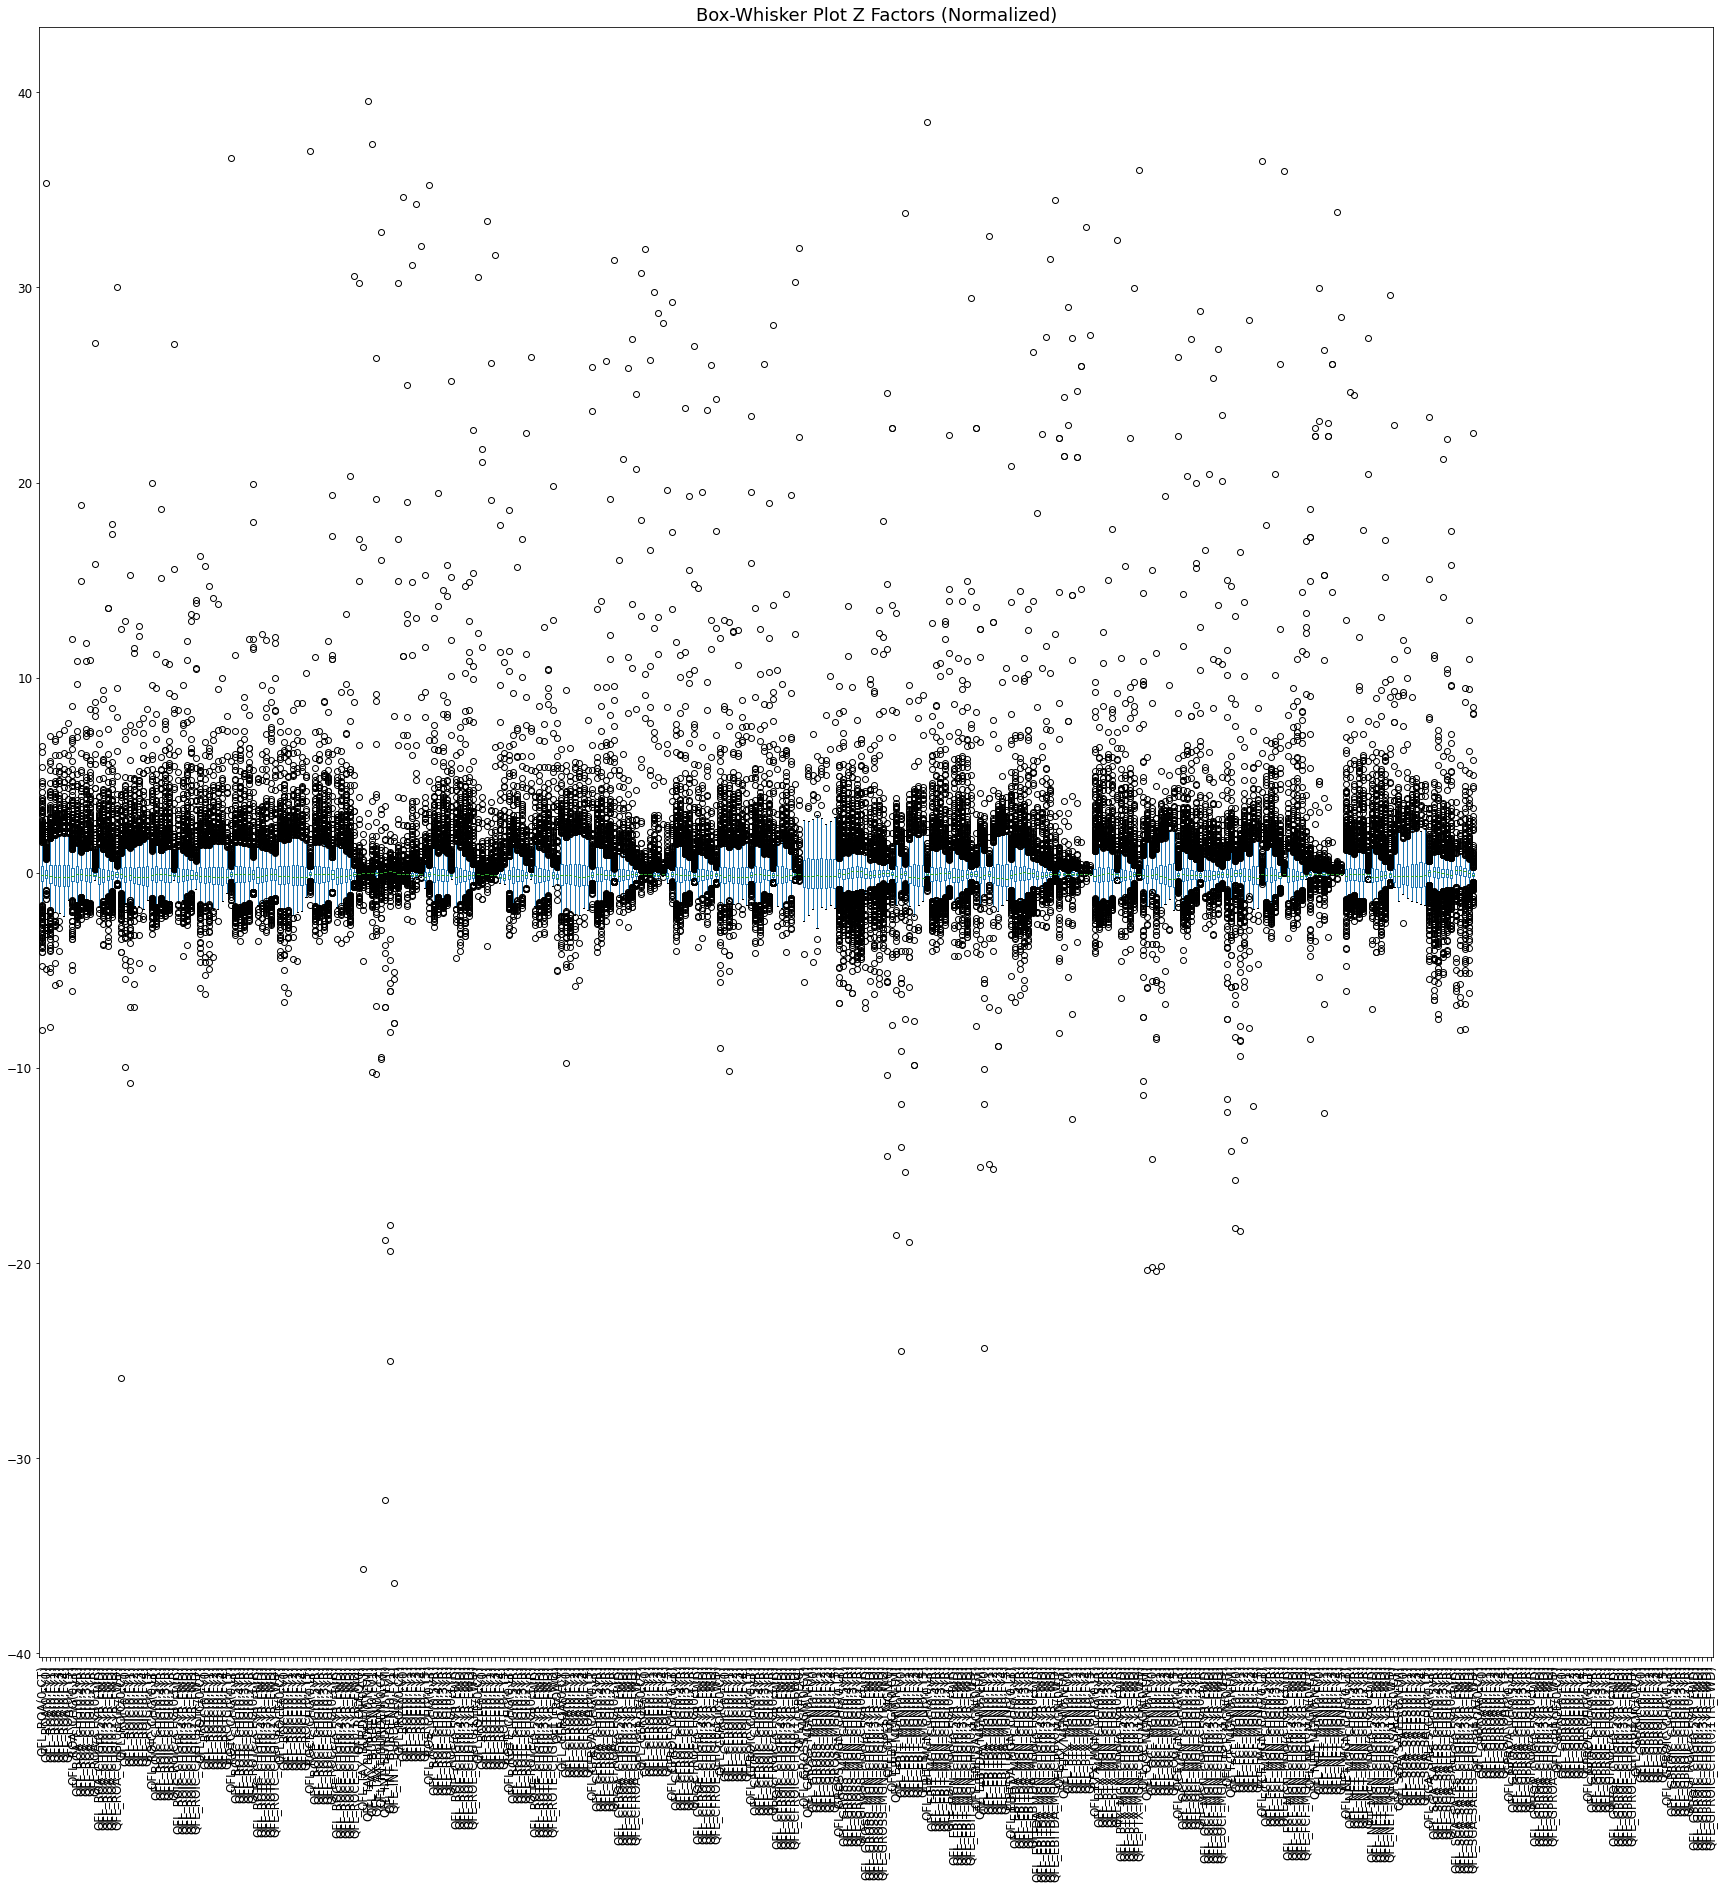

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
0      -8.039148       -4.954436       -7.913285       -5.764273   
1      -4.774670       -3.115964       -5.072447       -4.608326   
2      -4.046350       -2.954046       -4.863255       -3.658335   
3      -4.045646       -2.843373       -3.983859       -3.337353   
4      -3.859218       -2.799038       -3.951106       -2.742747   

   QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
0       -5.638632       -2.225502       -1.399525          -6.066100   
1       -3.991727       -1.960077       -1.320368          -4.977513   
2       -2.840699       -1.863068       -1.286890          -4.711836   
3       -2.473694       -1.794687       -1.285476          -3.387086   
4       -2.066214       -1.765955       -1.281464          -3.387086   

   QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
0           -2.680199           -2.363070           -2.189497   
1           -2.644416           -2.171579           -2.117428   
2           -2.539114           -2.092689           -1.976893   
3           -2.281002           -1.984478           -1.952536   
4           -2.249278           -1.940650           -1.829492   

   QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
0           -2.098640           -0.347628               -2.474318   
1           -1.985407           -0.346363               -2.077783   
2           -1.963653           -0.346168               -1.861935   
3           -1.888417           -0.346103               -1.741756   
4           -1.849525           -0.346040               -1.725990   

   QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
0               -3.722873               -3.729310               -2.258665   
1               -3.668068               -3.519698               -2.123599   
2               -2.620335               -3.276463               -2.019393   
3               -2.281174               -2.916209               -2.015169   
4               -2.281174               -2.557506               -2.015169   

   QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0,CT)  QFL_ROIC(0,FY0)  QFL_ROIC(0,FY1)  \
0               -0.612505      -25.883282        -9.966301       -10.758553   
1               -0.611524       -4.055592        -5.446792        -6.892855   
2               -0.609675       -4.051400        -4.710317        -5.000935   
3               -0.609675       -3.377443        -4.395340        -4.496391   
4               -0.607115       -3.094339        -3.330982        -3.604464   

   QFL_ROIC(0,FY2)  QFL_ROIC(0,FY3)  QFL_ROIC(0,FY4)  QFL_ROIC(0,FY5)  \
0        -6.870366        -4.599617        -2.369789        -1.376385   
1        -5.688837        -3.192115        -2.209743        -1.215504   
2        -3.213189        -2.323501        -1.831863        -1.182415   
3        -2.464376        -1.928005        -1.784623        -1.156300   
4        -2.143594        -1.710143        -1.768298        -1.144575   

   QFL_ROIC_CHG(0,LT)  QFL_ROIC_CHG(0,5YR)  QFL_ROIC_CHG(0,4YR)  \
0           -4.879860            -2.750505            -2.294925   
1           -3.150743            -2.606316            -2.151392   
2           -2.831214            -2.583164            -2.072191   
3           -2.760829            -2.450378            -2.006132   
4           -2.638595            -2.332910            -1.900312   

   QFL_ROIC_CHG(0,3YR)  QFL_ROIC_CHG(0,2YR)  QFL_ROIC_CHG(0,1YR)  \
0            -2.220418            -2.042447            -0.344736   
1            -2.156824            -1.928078            -0.343441   
2            -2.037324            -1.912069            -0.343395   
3            -1.978736            -1.837558            -0.343317   
4            -1.901812            -1.805160            -0.343141   

   QFL_ROIC_CHG(0,5YR_FWD)  QFL_ROIC_CHG(0,4YR_FWD)  QFL_ROIC_CHG(0,3YR_FWD)  \
0                -2.492740                -4.267460                -3.716378   
1     

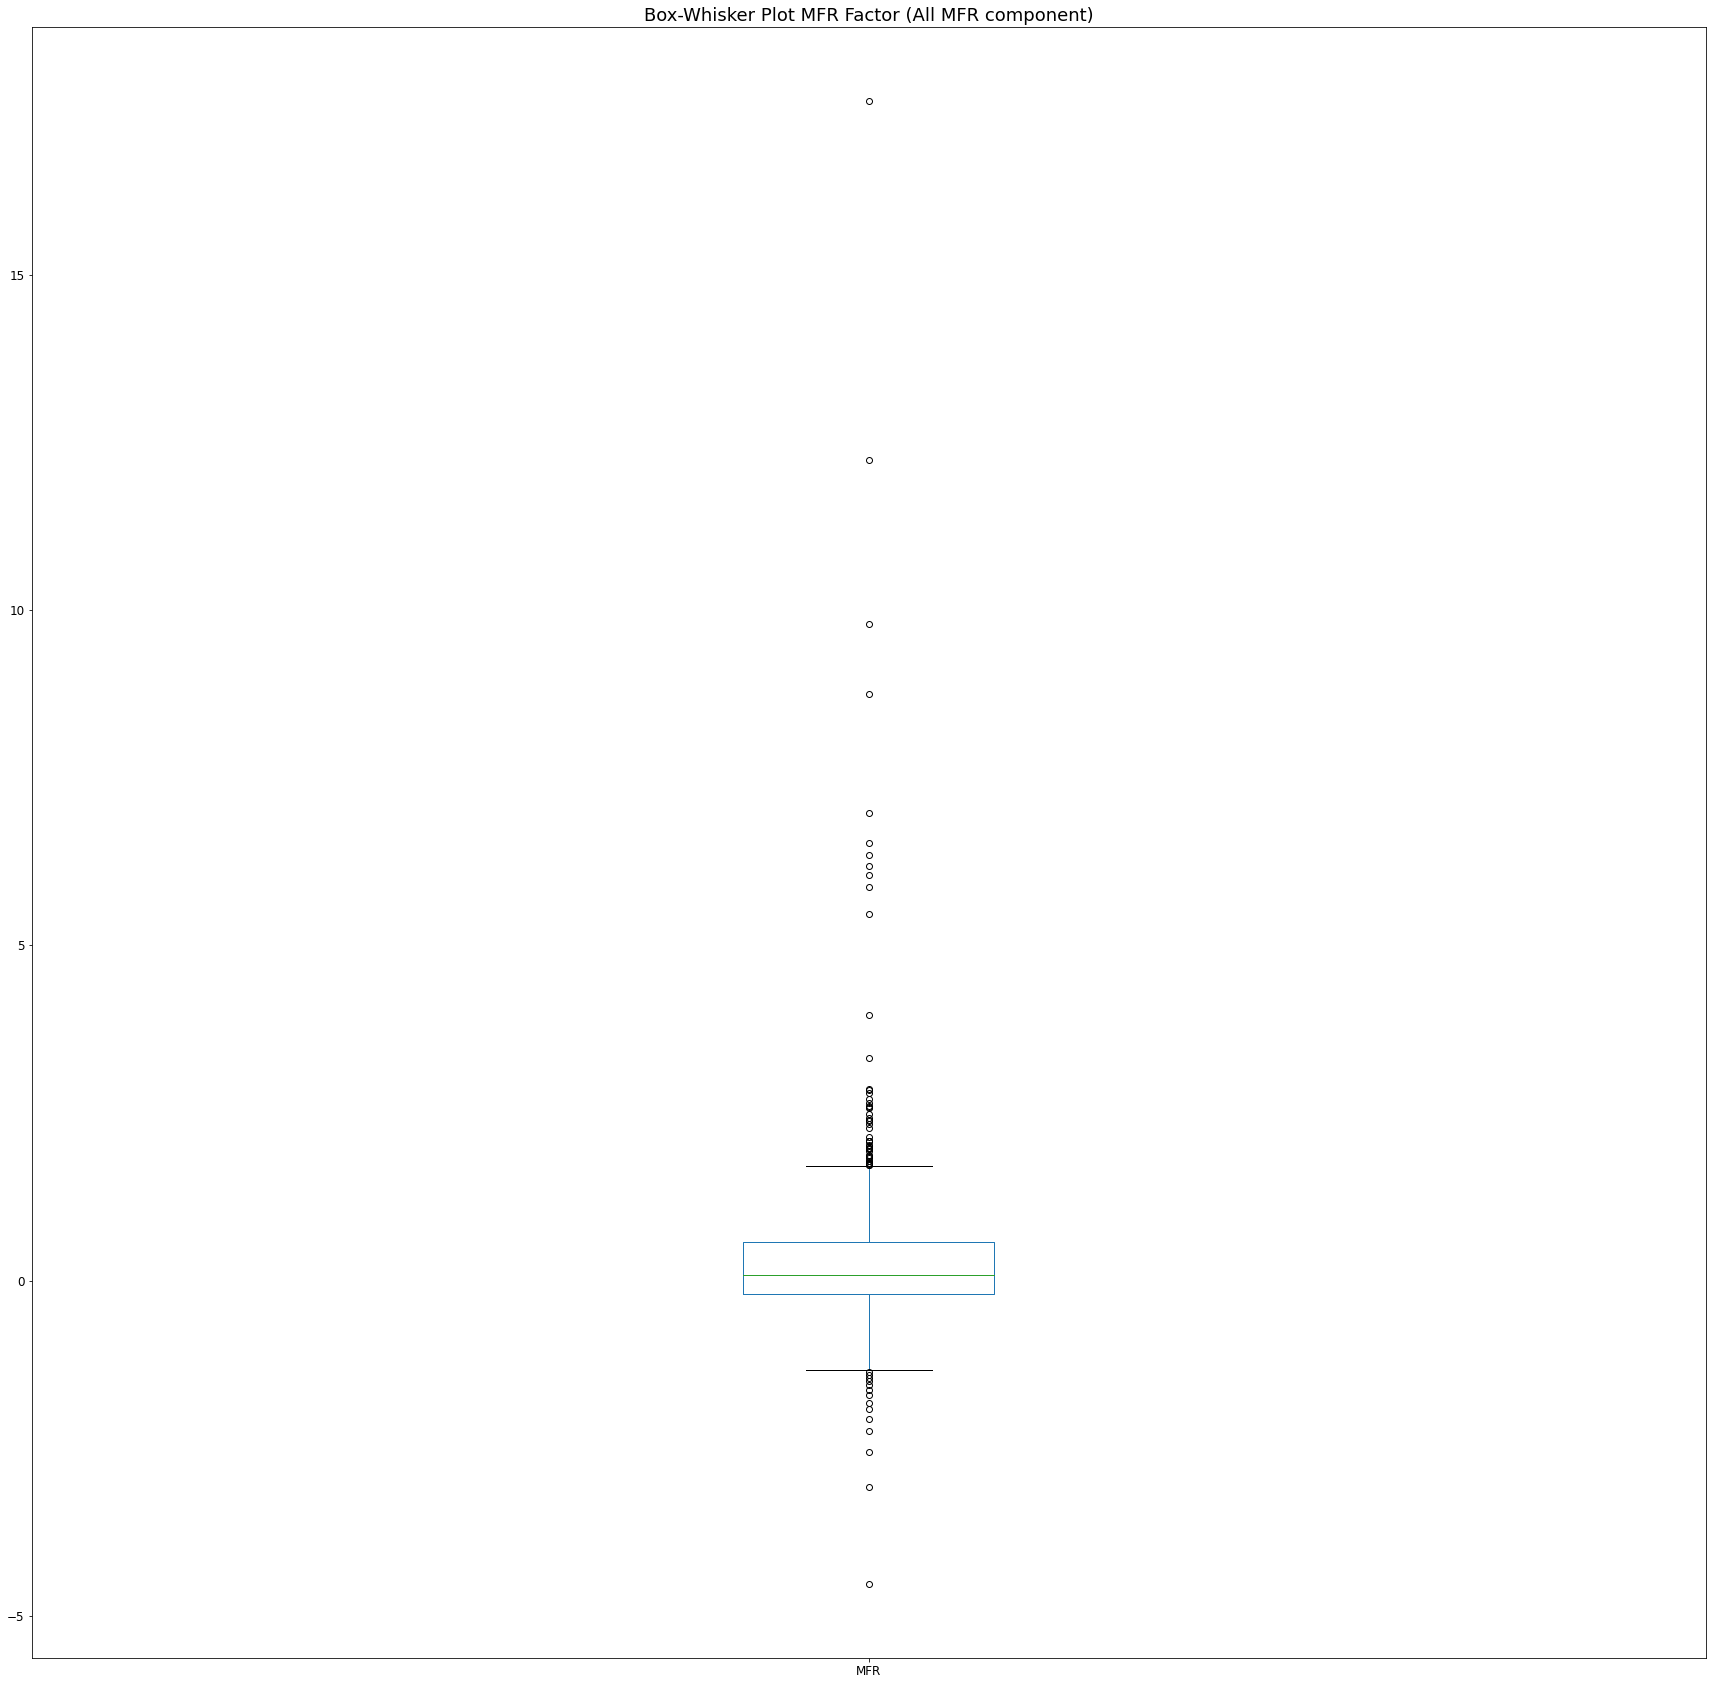

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

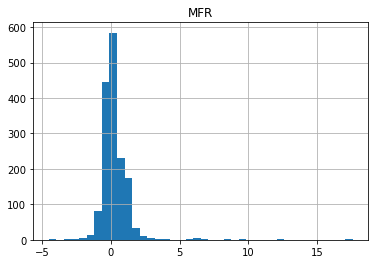

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.06


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


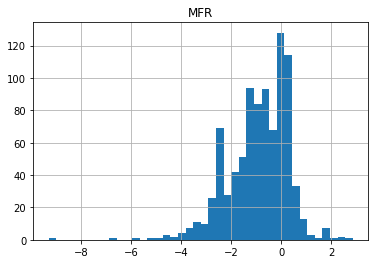

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
0         17.495182       17.334135       20.581772       21.597366   
1         16.383467       15.064973       16.411192       16.463854   
2          7.325403        5.974798        6.859622        7.127007   
3         18.522102       16.024446       18.347730       16.923254   
4         12.845562       13.502234       12.067489       12.656469   
...             ...             ...             ...             ...   
1595       1.201806        3.835927        1.060880        3.421819   
1596       2.421886        2.378841        2.159939        2.049070   
1597       1.548515        3.885987        0.594491        2.303547   
1598     -12.857943       -1.318838      -17.022030       -0.453034   
1599       2.459806        2.032687        3.300313        3.915555   

      QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
0          19.915457       16.531977       13.965553          -3.813445   
1          17.188112             NaN             NaN          10.845449   
2           8.813777       10.137152       11.324541          20.001276   
3          17.261969       17.923240       17.715437           3.834396   
4          12.820989       13.110156       13.594206           1.192519   
...              ...             ...             ...                ...   
1595        3.292215             NaN             NaN          -0.176746   
1596        1.978547        1.944669        2.195775          -3.694353   
1597        2.403671             NaN             NaN          -3.962629   
1598        1.456539        1.303159        2.247421                NaN   
1599        3.968373        4.062356        4.047052           8.128568   

      QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
0              -0.258195            5.624497            7.707214   
1              21.400750           25.438917           45.777320   
2              43.456398           29.352260           31.551147   
3              13.723839           -0.993961          -10.664331   
4               2.536368            4.471326           16.086578   
...                  ...                 ...                 ...   
1595          -11.131727          -16.576840          -26.020086   
1596           -8.165646           -7.561594           -0.074011   
1597           -8.453542          -23.437256          -30.975830   
1598                 NaN                 NaN                 NaN   
1599           -7.408452          -21.510761          -30.349117   

      QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
0               6.247187           10.890425               -5.063919   
1              31.695759            3.801775                     NaN   
2              -8.634085            9.943914               13.984398   
3             -13.144445           14.429867                1.297485   
4               5.084801           -8.487946                0.847786   
...                  ...                 ...                     ...   
1595          -41.856373          -70.930490                     NaN   
1596           61.761950            2.812576               -2.121120   
1597          -28.412354          -48.754684                     NaN   
1598                 NaN                 NaN                     NaN   
1599          -38.717037          -39.228970               12.363096   

      QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
0                  -1.268605                4.755837               11.621874   
1                        NaN                4.067971                4.539778   
2                  13.973723               12.800846                9.217440   
3                   1.643005                1.433716                2.766228   
4                   0.016328               -1.070839               -3.182589   
...                      ...                     ...                     ...   
1595      

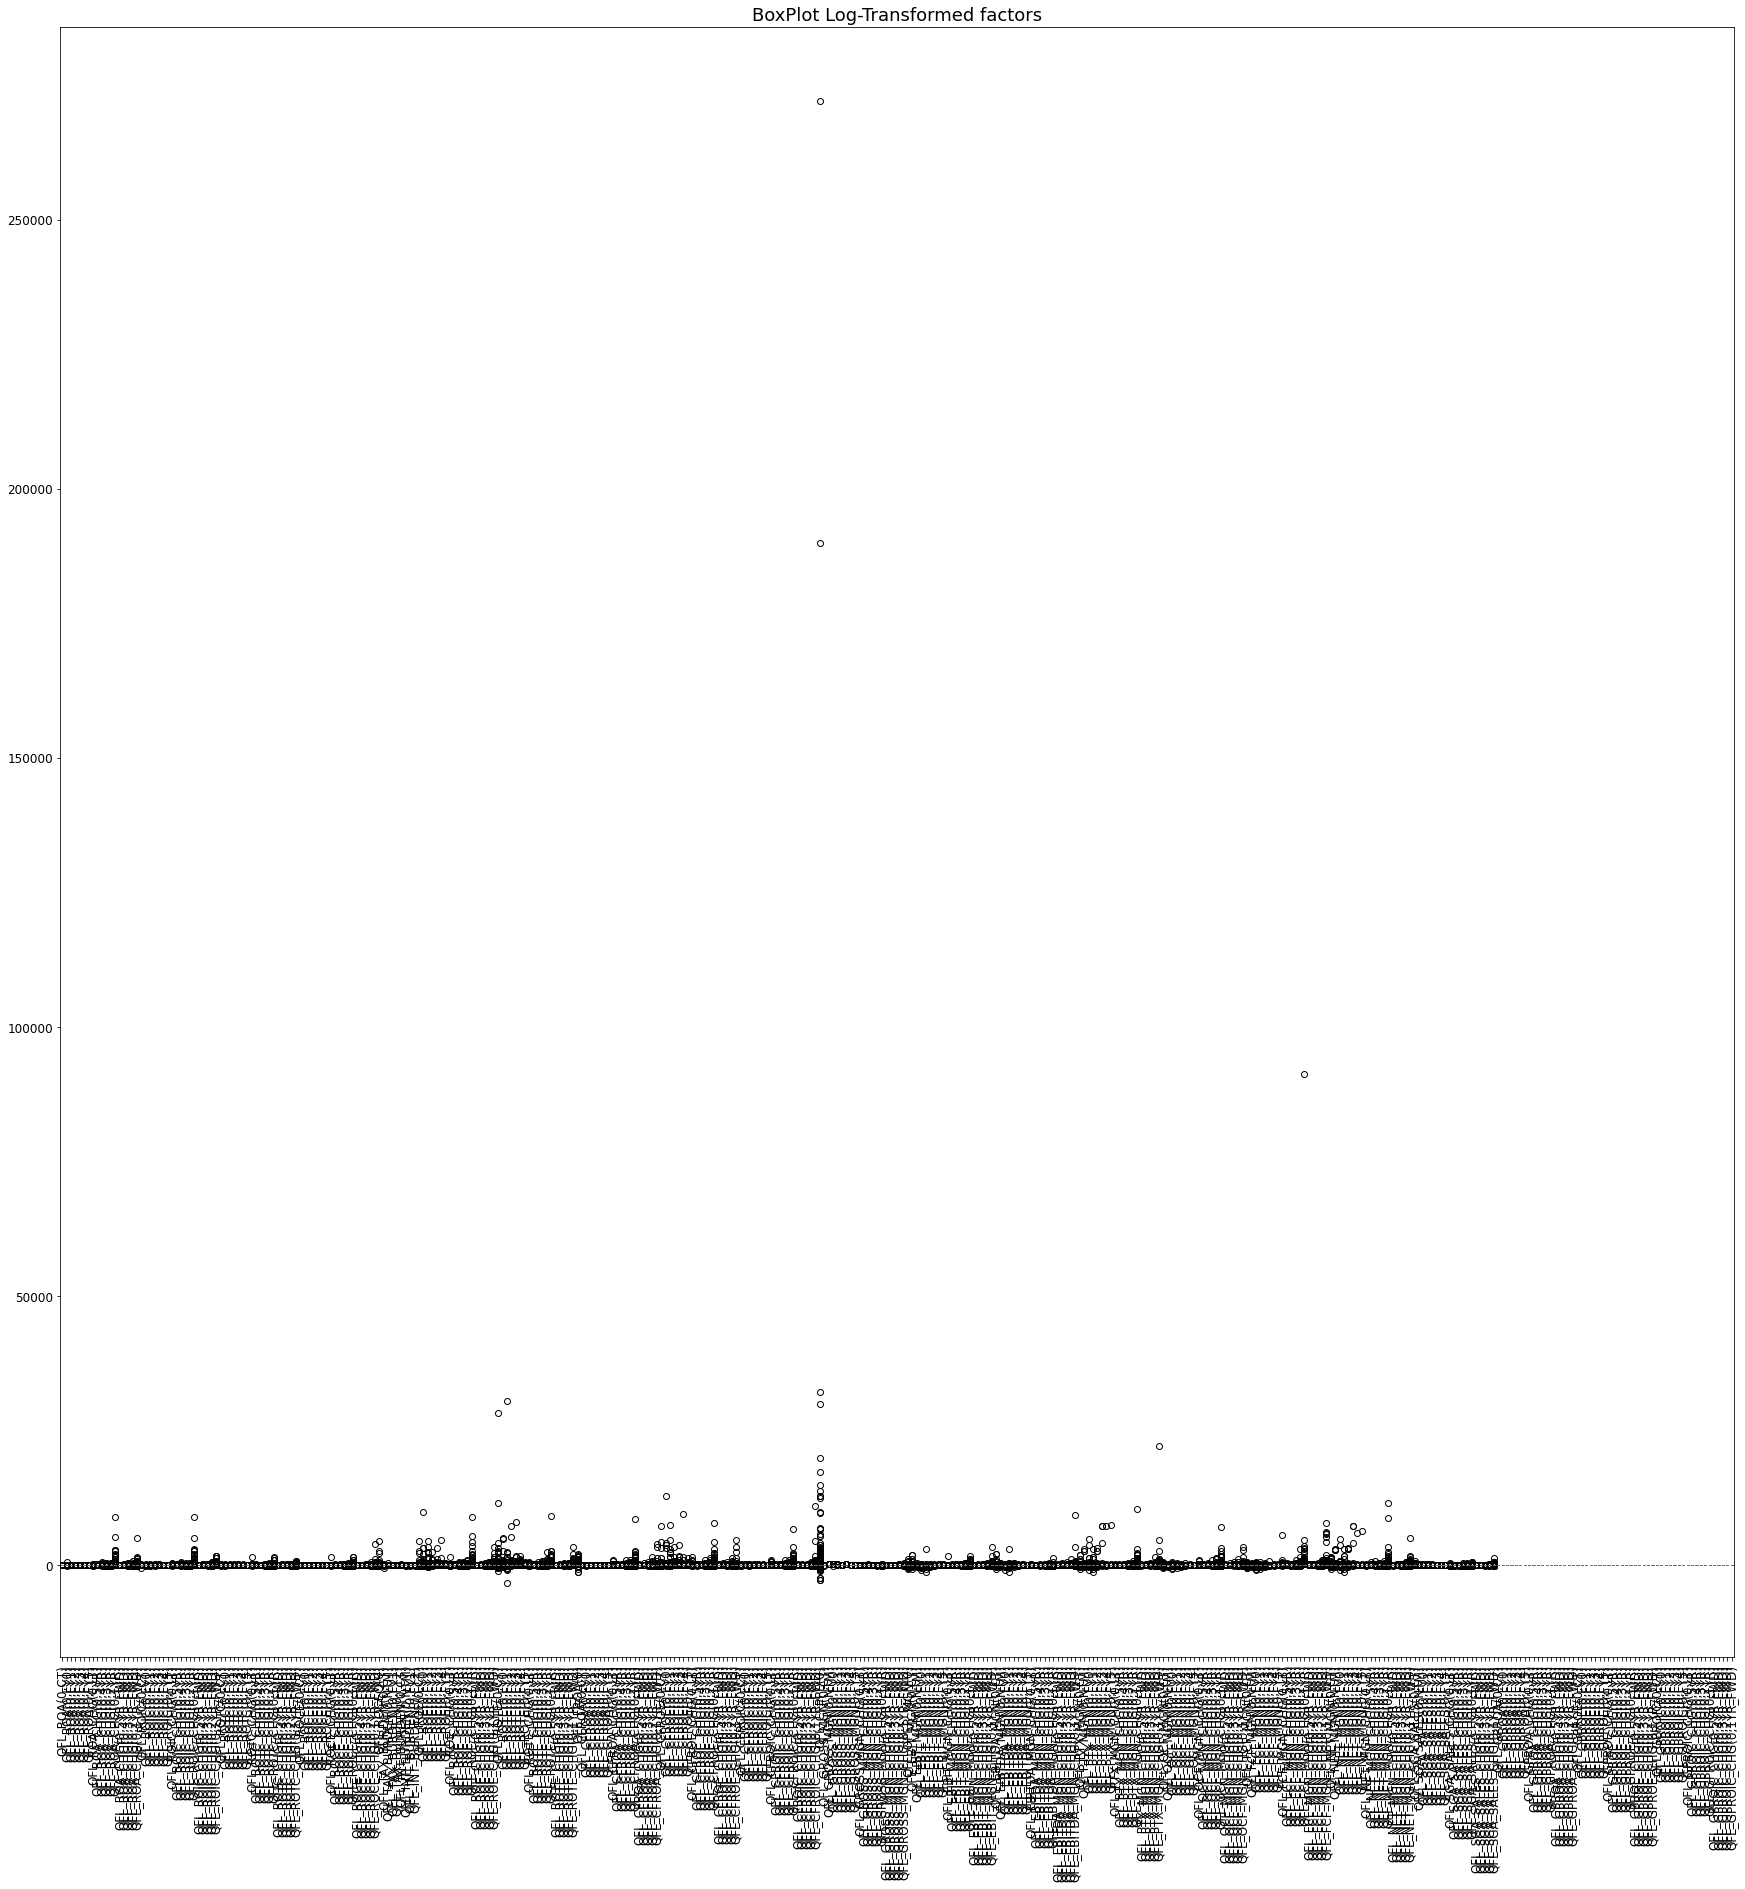

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  QFL_ROA(0,FY2)  \
0       1.824347        0.659919        2.261324        2.620693   
1       1.676282        0.524562        1.662900        1.761206   
2       0.469876       -0.017676        0.292374        0.197968   
3       1.961118        0.581795        1.940768        1.838121   
4       1.205083        0.431343        1.039635        1.123748   

   QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  QFL_ROA_CHG(0,LT)  \
0        2.304534        1.677098        1.180992          -0.600121   
1        1.835491             NaN             NaN           0.416347   
2        0.395289        0.554607        0.708943           1.051224   
3        1.848192        1.921308        1.851238          -0.069809   
4        1.084442        1.076462        1.114618          -0.253001   

   QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  QFL_ROA_CHG(0,3YR)  \
0           -0.064060            0.170270            0.288403   
1            1.071067            0.818238            1.365728   
2            2.226984            0.946211            0.963149   
3            0.668726           -0.046166           -0.231484   
4            0.082401            0.132559            0.525526   

   QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  QFL_ROA_CHG(0,5YR_FWD)  \
0            0.331267           -0.007678               -0.992693   
1            0.923985           -0.029453                     NaN   
2           -0.015331           -0.010585                0.439101   
3           -0.120381            0.003195               -0.514529   
4            0.304194           -0.067205               -0.548331   

   QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  QFL_ROA_CHG(0,2YR_FWD)  \
0               -0.517351               -0.038747                0.217211   
1                     NaN               -0.069810                0.045930   
2                0.402454                0.324550                0.159059   
3               -0.341649               -0.188768                0.003037   
4               -0.439812               -0.301868               -0.140836   

   QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0,CT)  QFL_ROIC(0,FY0)  QFL_ROIC(0,FY1)  \
0                0.089439        1.512499         1.728714         2.340481   
1                0.031480        1.083169         0.846104         1.314913   
2                0.066217        0.384373         0.182586         0.612192   
3                0.064378        0.918985         1.064761         1.052625   
4               -0.084222        0.586660         0.401590         0.519901   

   QFL_ROIC(0,FY2)  QFL_ROIC(0,FY3)  QFL_ROIC(0,FY4)  QFL_ROIC(0,FY5)  \
0         3.204760         3.102826         1.784909         1.021047   
1         1.441464         1.441225              NaN              NaN   
2         0.527878         0.637172         0.814854         1.063193   
3         0.939449         0.855479         0.938670         0.995792   
4         0.521423         0.428538         0.447264         0.578785   

   QFL_ROIC_CHG(0,LT)  QFL_ROIC_CHG(0,5YR)  QFL_ROIC_CHG(0,4YR)  \
0           -0.526959             0.136462             0.358042   
1            0.498970             1.000648             0.762997   
2            0.579314             1.820541             0.671808   
3           -0.162061             0.790924             0.061027   
4           -0.109832             0.193498             0.239403   

   QFL_ROIC_CHG(0,3YR)  QFL_ROIC_CHG(0,2YR)  QFL_ROIC_CHG(0,1YR)  \
0             0.505991             0.461795             0.002211   
1             1.369261             0.874393            -0.031114   
2             0.774239            -0.081146            -0.016656   
3            -0.130468            -0.043930             0.004799   
4             0.650496             0.318857            -0.066704   

   QFL_ROIC_CHG(0,5YR_FWD)  QFL_ROIC_CHG(0,4YR_FWD)  QFL_ROIC_CHG(0,3YR_FWD)  \
0                -1.115704                -0.392886                 0.387079   
1     

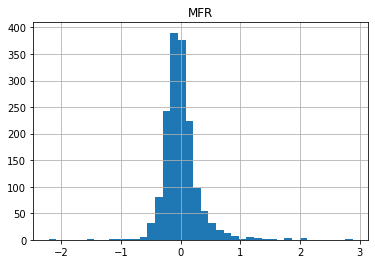

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.01
Information Coefficient (P-Value): 0.79


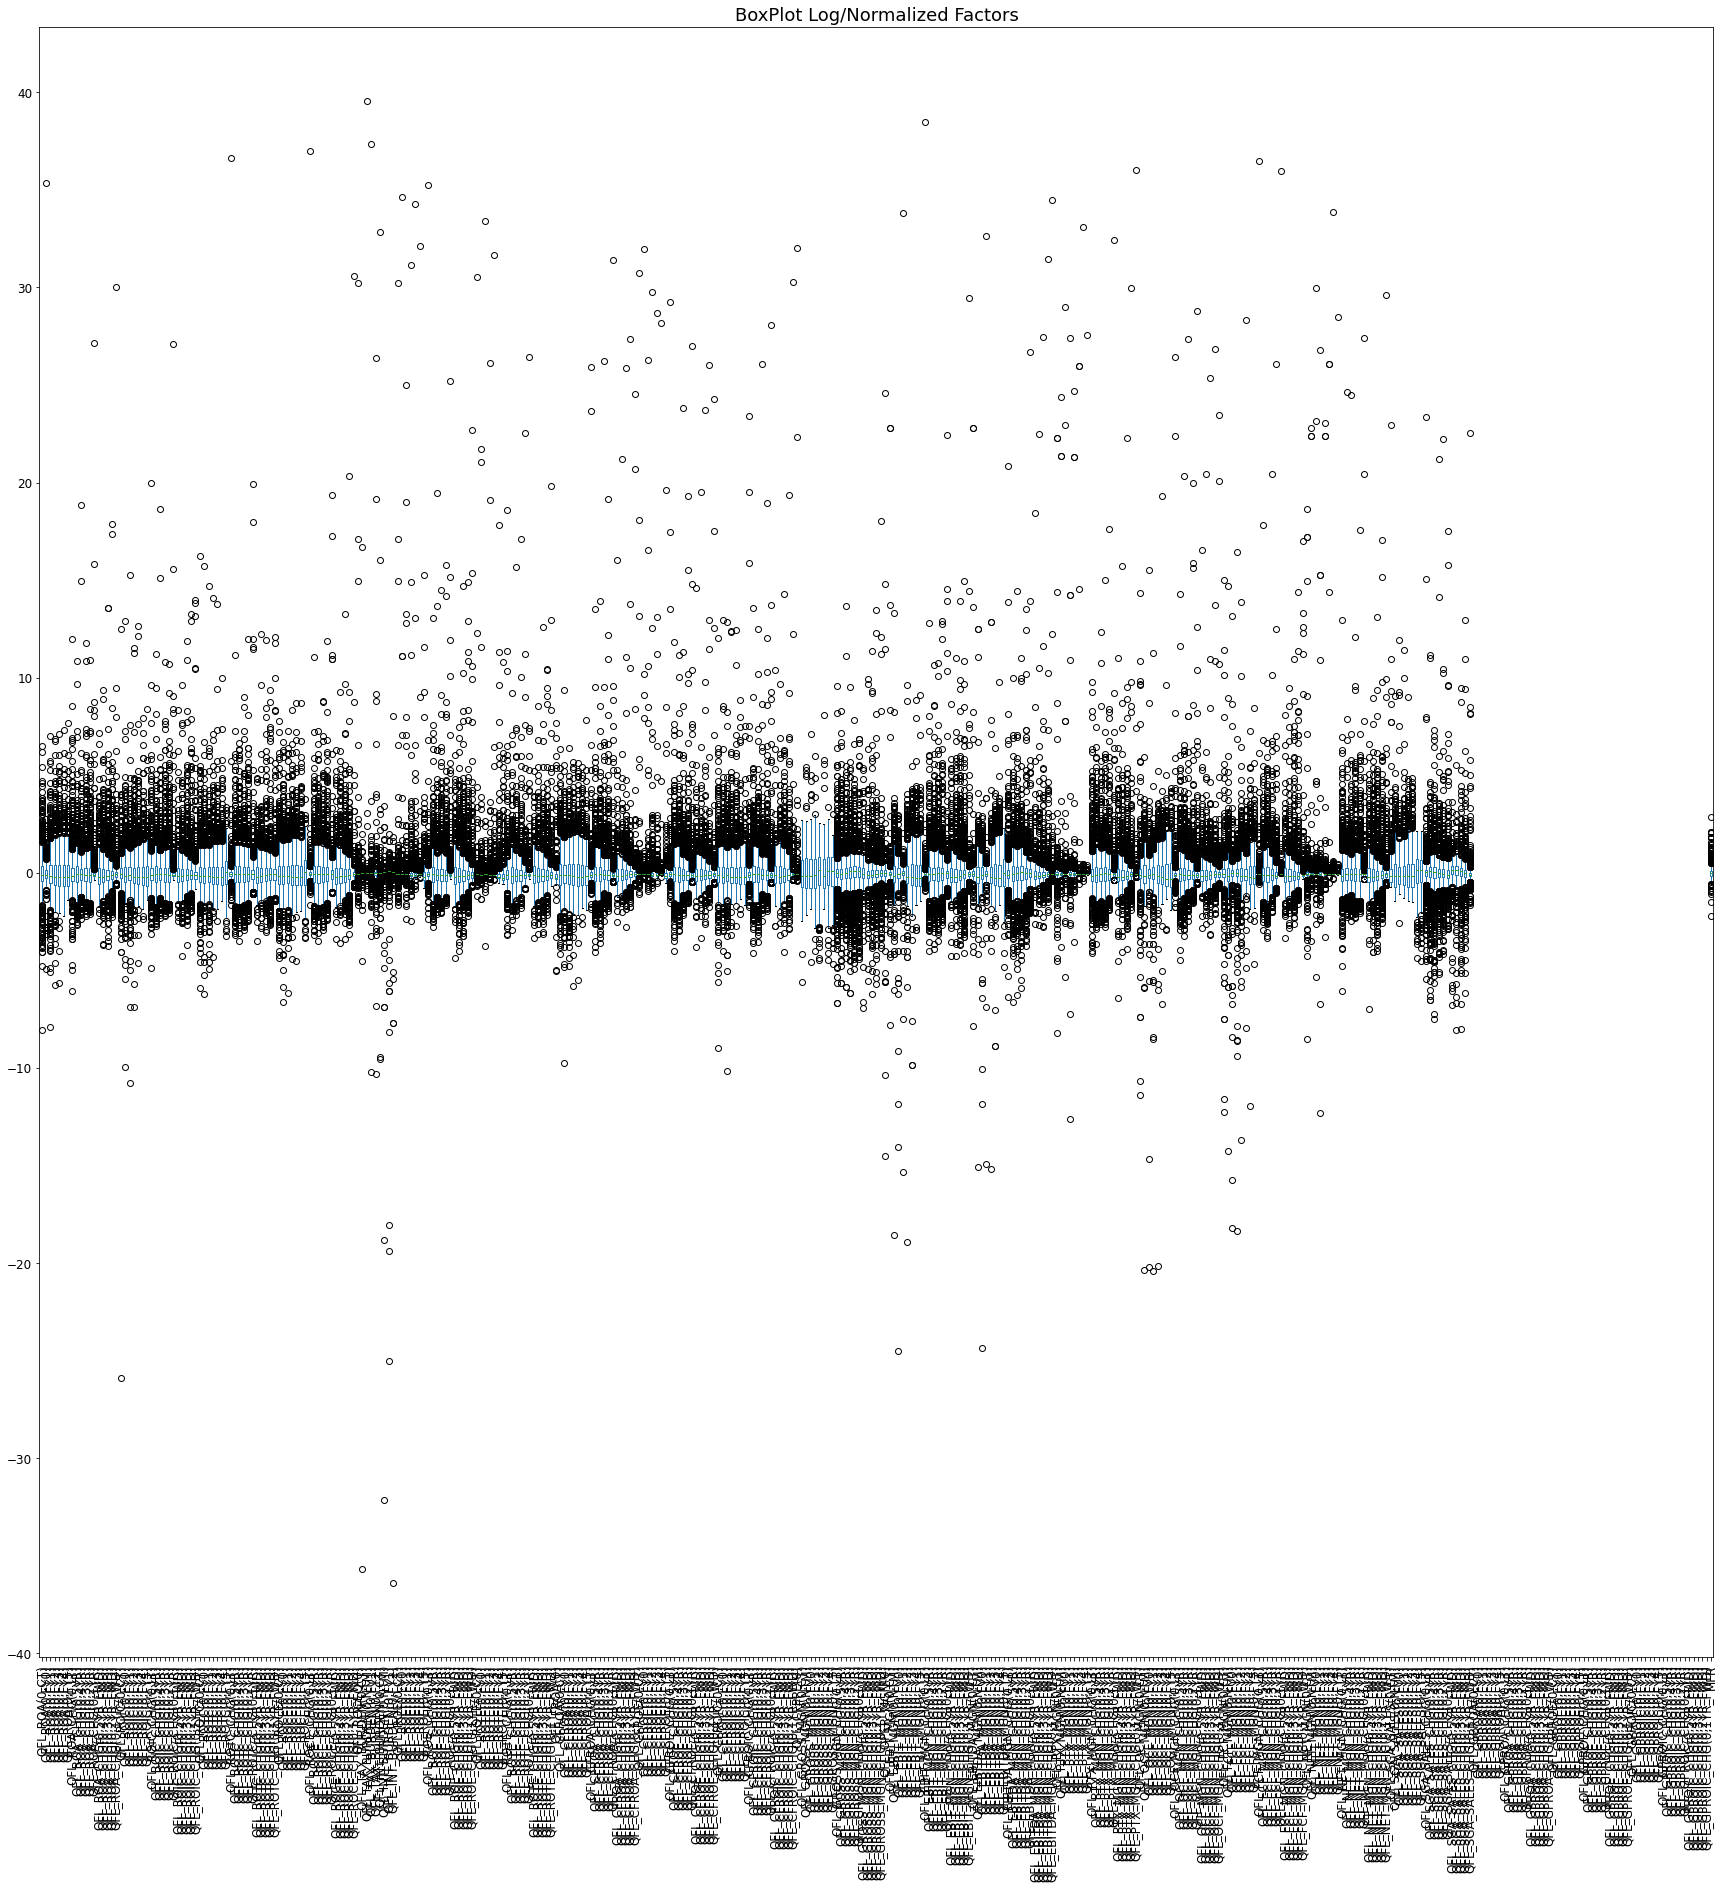

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

BENCHMARK_ID         DATE SECURITY_ID    Weight             proper_name  \
0        890100  30-Nov-2020    03783310  4.204100              Apple Inc.   
1        890100  30-Nov-2020    59491810  3.141281   Microsoft Corporation   
2        890100  30-Nov-2020    02313510  2.735749        Amazon.com, Inc.   
3        890100  30-Nov-2020    30303M10  1.356526  Facebook, Inc. Class A   
4        890100  30-Nov-2020    02079K10  1.085045   Alphabet Inc. Class C   

           fg_gics_sector         proper  p_total_return qfl_size_class  \
0  Information Technology  United States       11.457372       Mega Cap   
1  Information Technology  United States        3.900588       Mega Cap   
2  Consumer Discretionary  United States        2.805829       Mega Cap   
3  Communication Services  United States       -1.375598       Mega Cap   
4  Communication Services  United States       -0.503194       Mega Cap   

   qfl_mkt_val_sec  QFL_ROA(0,CT)  QFL_ROA(0,FY0)  QFL_ROA(0,FY1)  \
0        2024064.4      17.495182       17.334135       20.581772   
1        1618475.4      16.383467       15.064973       16.411192   
2        1589567.8       7.325403        5.974798        6.859622   
3         665827.3      18.522102       16.024446       18.347730   
4         580810.4      12.845562       13.502234       12.067489   

   QFL_ROA(0,FY2)  QFL_ROA(0,FY3)  QFL_ROA(0,FY4)  QFL_ROA(0,FY5)  \
0       21.597366       19.915457       16.531977       13.965553   
1       16.463854       17.188112             NaN             NaN   
2        7.127007        8.813777       10.137152       11.324541   
3       16.923254       17.261969       17.923240       17.715437   
4       12.656469       12.820989       13.110156       13.594206   

   QFL_ROA_CHG(0,LT)  QFL_ROA_CHG(0,5YR)  QFL_ROA_CHG(0,4YR)  \
0          -3.813445           -0.258195            5.624497   
1          10.845449           21.400750           25.438917   
2          20.001276           43.456398           29.352260   
3           3.834396           13.723839           -0.993961   
4           1.192519            2.536368            4.471326   

   QFL_ROA_CHG(0,3YR)  QFL_ROA_CHG(0,2YR)  QFL_ROA_CHG(0,1YR)  \
0            7.707214            6.247187           10.890425   
1           45.777320           31.695759            3.801775   
2           31.551147           -8.634085            9.943914   
3          -10.664331          -13.144445           14.429867   
4           16.086578            5.084801           -8.487946   

   QFL_ROA_CHG(0,5YR_FWD)  QFL_ROA_CHG(0,4YR_FWD)  QFL_ROA_CHG(0,3YR_FWD)  \
0               -5.063919               -1.268605                4.755837   
1                     NaN                     NaN                4.067971   
2               13.984398               13.973723               12.800846   
3                1.297485                1.643005                1.433716   
4                0.847786                0.016328               -1.070839   

   QFL_ROA_CHG(0,2YR_FWD)  QFL_ROA_CHG(0,1YR_FWD)  QFL_ROIC(0,CT)  \
0               11.621874               18.735504       32.092083   
1                4.539778                8.936083       24.711168   
2                9.217440               14.809263       12.697678   
3                2.766228               14.498377       21.888575   
4               -3.182589              -10.625988       16.175348   

   QFL_ROIC(0,FY0)  QFL_ROIC(0,FY1)  QFL_ROIC(0,FY2)  QFL_ROIC(0,FY3)  \
0        31.912125        42.259876        46.953262        46.197777   
1        21.235376        27.484417        26.968940        27.723780   
2        13.208933        17.360264        16.614810        18.784160   
3        23.880419        23.705614        21.279350        21.211336   
4        15.858176        16.030617        16.541656        16.464525   

   QFL_ROIC(0,FY4)  QFL_ROIC(0,FY5)  QFL_ROIC_CHG(0,LT)  QFL_ROIC_CHG(0,5YR)  \
0        29.589880        20.669245           -5.789325             2.916956   


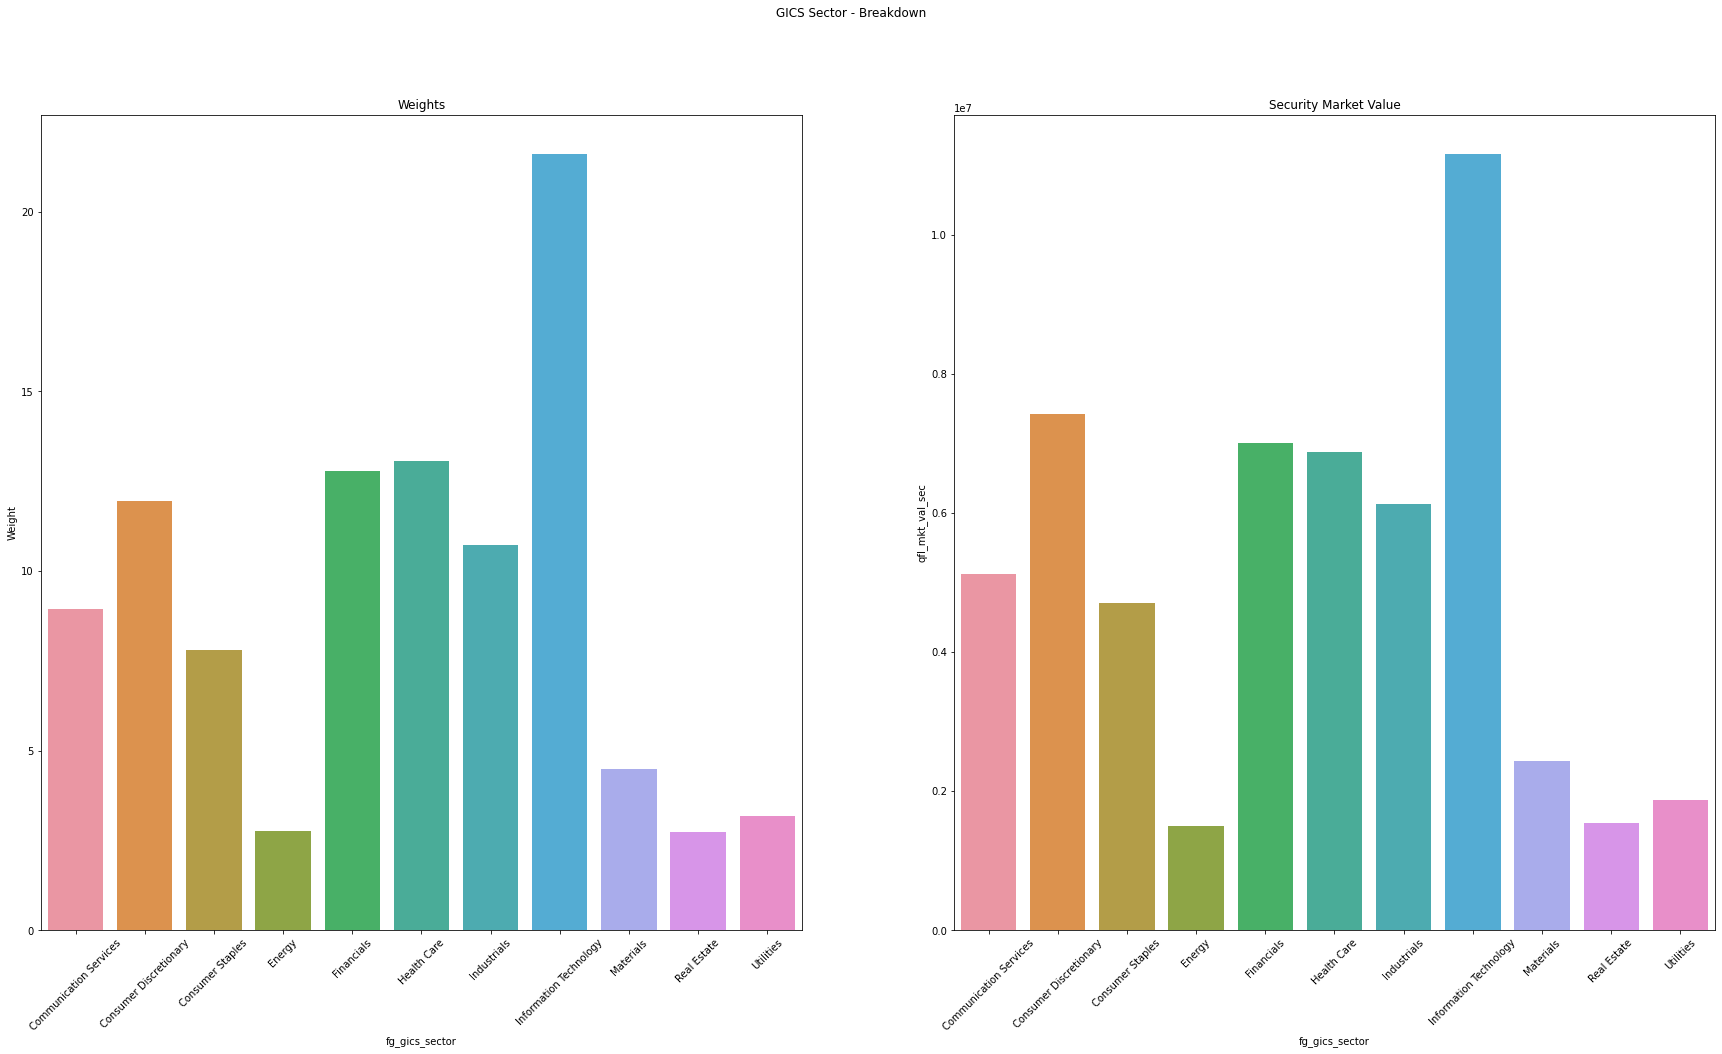

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

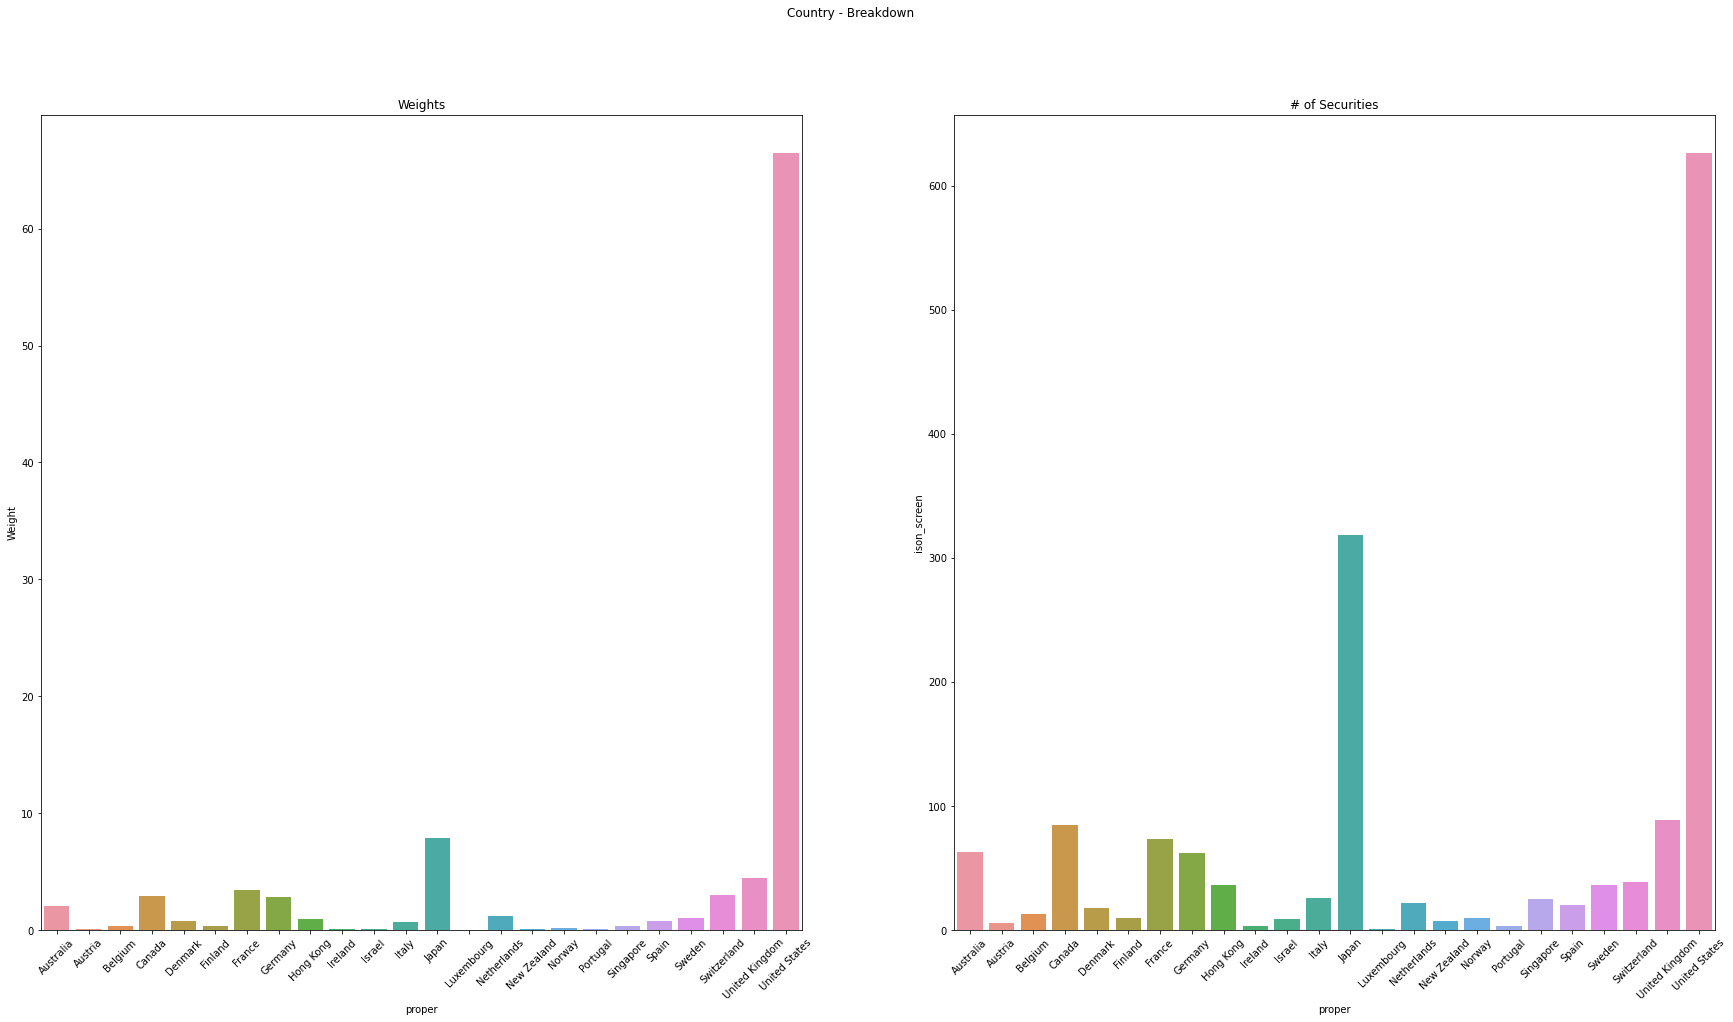

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

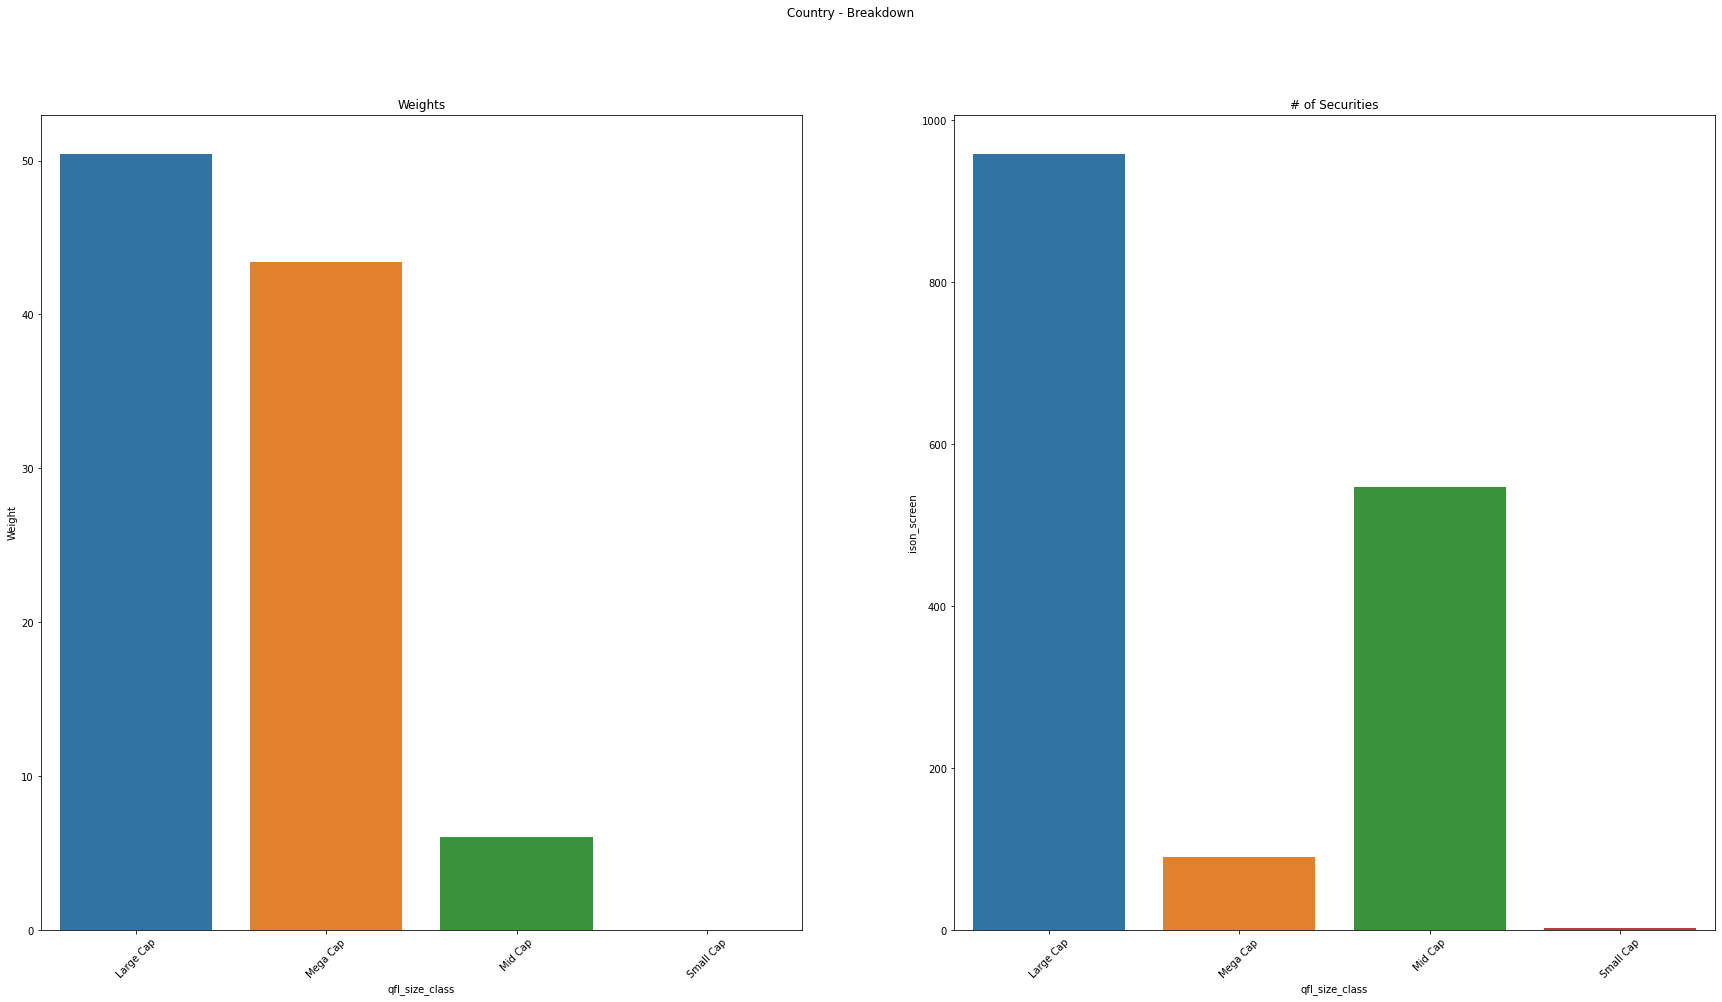

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.53093121900747, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.53093121900747, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(


Num Features: 3
Selected Features: [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
  True False False False False False False False False False]
Feature Ranking: [ 1 14 33 32 31 30  3 22 39 16 12 46 49 48 42 50 52 54 56 25 34 23 24 36
 29 17 26  7 28 55 53 51  2 47 10 38  5 41 44  1  4 11 45 43 13 20 21 35
  1  8  6  9 15 37 18 27 40 19]


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_ROA(0,CT)', 'QFL_EBITDA_MGN_CHG(0,3YR)', 'QFL_PTX_MGN_CHG(0,LT)'], dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

QFL_ROA(0,CT)  QFL_EBITDA_MGN_CHG(0,3YR)  \
QFL_ROA(0,CT)                   1.000000                   0.158747   
QFL_EBITDA_MGN_CHG(0,3YR)       0.158747                   1.000000   
QFL_PTX_MGN_CHG(0,LT)          -0.060878                   0.112098   

                           QFL_PTX_MGN_CHG(0,LT)  
QFL_ROA(0,CT)                          -0.060878  
QFL_EBITDA_MGN_CHG(0,3YR)               0.112098  
QFL_PTX_MGN_CHG(0,LT)                   1.000000

In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

QFL_ROA(0,CT)  QFL_EBITDA_MGN_CHG(0,3YR)  QFL_PTX_MGN_CHG(0,LT)
0         17.495182                  -3.916192               1.933275
1         16.383467                   6.963372               8.576622
2          7.325403                  16.249907              21.564383
3         18.522102                  -8.255661               1.117006
4         12.845562                  -5.334896              -0.953948
...             ...                        ...                    ...
1595       1.201806                   1.148796             -12.362909
1596       2.421886                  -7.095718              -2.552079
1597       1.548515                  -1.011068             -18.083382
1598     -12.857943                  11.073447             -39.498005
1599       2.459806                 -12.090105              -0.020830

[1600 rows x 3 columns]

In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

QFL_ROA(0,CT)  QFL_EBITDA_MGN_CHG(0,3YR)  QFL_PTX_MGN_CHG(0,LT)       MFR
0       1.826633                  -0.285575              -0.275001  0.422019
1       1.678383                   0.529516               0.291035  0.832978
2       0.470465                   1.225258               1.397636  1.031120
3       1.963575                  -0.610686              -0.344550  0.336113
4       1.206593                  -0.391864              -0.521002  0.097909

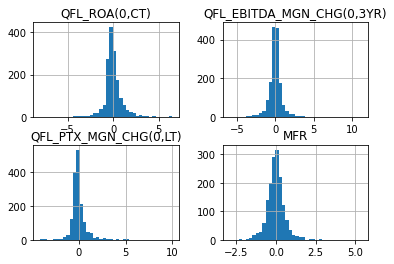

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.04
Information Coefficient (P-Value): 0.13


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.04
Information Coefficient (P-Value): 0.13


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.01
Information Coefficient (P-Value): 0.79


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.06
